In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import xarray as xr

import dask

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial' 
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["axes.linewidth"] = 1.50

from matplotlib.colors import LinearSegmentedColormap
cm_data = np.loadtxt("../../ScientificColourMaps7/batlow/batlow.txt")[::-1]
batlow_map = LinearSegmentedColormap.from_list('batlow', cm_data)

cm_data = np.loadtxt("../../ScientificColourMaps7/bamako/bamako.txt")[::-1]
bamako_map = LinearSegmentedColormap.from_list('bamako', cm_data)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import regionmask

### Preliminaries

In [2]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
path_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/results/'
data_path = '/storage/home/dcl5300/work/lafferty-sriver_inprep_tbd/data/'

nex_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/'
cil_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/cil-gdpcir/'
isi_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/isimip3b/regridded/conservative/'
cbp_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/carbonplan/'

poly_path = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/forced_response/'

In [3]:
###################
# Models
###################
from utils import nex_ssp_dict, cil_ssp_dict, isimip_ssp_dict, gardsv_ssp_dict, gardsv_var_dict, deepsdbc_dict

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())
cbp_gard_models = list(gardsv_ssp_dict.keys())
cbp_gard_precip_models = [model for model in cbp_gard_models if 'pr' in gardsv_var_dict[model]]
cbp_deep_models = list(deepsdbc_dict.keys())

In [4]:
################
# Cities
################
city_list = {'chicago':[41.881944, -87.627778],
              'lagos':[6.455027, 3.384082],
              'cairo':[30.044444, 31.235833],
              'seattle':[47.609722, -122.333056],
              'delhi':[28.613895, 77.209006],
              'houston':[29.762778, -95.383056],
              'mexicocity':[19.433333, -99.133333],
              'denver':[39.7392, -104.985],
              'nyc':[40.712778, -74.006111]}

In [5]:
##############################
# UC map plot
##############################
def plot_uc_map(metric, var_id, const_iav, deg, scenario_id, axs, fig, cbar, title):
    # Setup read paths
    uc_read_path = path_in + 'uncertainty_partitioning/' + metric + '_deg' + str(deg) + '.nc'
    iav_read_path = path_in + 'uncertainty_partitioning/' + metric + '_deg' + str(deg)
    if const_iav:
        iav_read_path += '_const_iav.nc'
    else:
        iav_read_path += '_nonconst_iav.nc'
        
    if metric in ['hot', 'wet', 'hotdry']:
        var_id_string = var_id.replace('_count', '').replace('_streak', '').replace('pr_', '')
        iav_read_path = iav_read_path.replace(metric, metric + '_' + var_id_string)
        uc_read_path = uc_read_path.replace(metric, metric + '_' + var_id_string)
    if metric == 'hotdry':
        # This was me being silly
        iav_read_path = iav_read_path.replace('hotdry_hotdry_', 'hotdry_')
        uc_read_path = uc_read_path.replace('hotdry_hotdry_', 'hotdry_')
    
    # Averaging periods
    early_start, early_end = 2020, 2039
    mid_start, mid_end = 2050, 2069
    late_start, late_end = 2080, 2099
    
    # Read
    ds_uc = xr.open_dataset(uc_read_path)
    ds_iav = xr.open_dataset(iav_read_path)
    if const_iav:
        ds_iav_early = ds_iav.expand_dims(dim={'time':np.arange(early_start,early_end+1)}).assign_coords(uncertainty = 'variability')
        ds_iav_mid = ds_iav.expand_dims(dim={'time':np.arange(mid_start,mid_end+1)}).assign_coords(uncertainty = 'variability')
        ds_iav_late = ds_iav.expand_dims(dim={'time':np.arange(late_start,late_end+1)}).assign_coords(uncertainty = 'variability')
    else:
        ds_iav_early = ds_iav.sel(time = slice(early_start, early_end)).assign_coords(uncertainty = 'variability')
        ds_iav_mid = ds_iav.sel(time = slice(mid_start, mid_end)).assign_coords(uncertainty = 'variability')
        ds_iav_late = ds_iav.sel(time = slice(late_start, late_end)).assign_coords(uncertainty = 'variability')
            
    # Concat and resample to 3 epochs
    ds_early = xr.concat([ds_iav_early, ds_uc.sel(time = slice(early_start, early_end))], dim='uncertainty')[var_id].mean(dim='time')
    ds_mid = xr.concat([ds_iav_mid, ds_uc.sel(time = slice(mid_start, mid_end))], dim='uncertainty')[var_id].mean(dim='time')
    ds_late = xr.concat([ds_iav_late, ds_uc.sel(time = slice(late_start, late_end))], dim='uncertainty')[var_id].mean(dim='time')

    # Get 'total' uncertainty
    scenario = 'scenario_' + scenario_id
    
    Utotal_early = ds_early.sel(uncertainty='model') + ds_early.sel(uncertainty=scenario) + ds_early.sel(uncertainty='ensemble') + ds_early.sel(uncertainty='variability')
    Utotal_mid = ds_mid.sel(uncertainty='model') + ds_mid.sel(uncertainty=scenario) + ds_mid.sel(uncertainty='ensemble') + ds_mid.sel(uncertainty='variability')
    Utotal_late = ds_late.sel(uncertainty='model') + ds_late.sel(uncertainty=scenario) + ds_late.sel(uncertainty='ensemble') + ds_late.sel(uncertainty='variability')

    # Get fractions and average for each epoch
    Ufrac_model_early = 100 * (ds_early.sel(uncertainty='model') / Utotal_early)#.mean(dim='time')
    Ufrac_scenario_early = 100 * (ds_early.sel(uncertainty=scenario) / Utotal_early)#.mean(dim='time')
    Ufrac_ensemble_early = 100  * (ds_early.sel(uncertainty='ensemble') / Utotal_early)#.mean(dim='time')
    Ufrac_iav_early = 100 * (ds_early.sel(uncertainty='variability') / Utotal_early)#.mean(dim='time')

    Ufrac_model_mid = 100 * (ds_mid.sel(uncertainty='model') / Utotal_mid)#.mean(dim='time')
    Ufrac_scenario_mid = 100 * (ds_mid.sel(uncertainty=scenario) / Utotal_mid)#.mean(dim='time')
    Ufrac_ensemble_mid = 100 * (ds_mid.sel(uncertainty='ensemble') / Utotal_mid)#.mean(dim='time')
    Ufrac_iav_mid = 100 * (ds_mid.sel(uncertainty='variability') / Utotal_mid)#.mean(dim='time')

    Ufrac_model_late = 100 * (ds_late.sel(uncertainty='model') / Utotal_late)#.mean(dim='time')
    Ufrac_scenario_late = 100 * (ds_late.sel(uncertainty=scenario) / Utotal_late)#.mean(dim='time')
    Ufrac_ensemble_late = 100 * (ds_late.sel(uncertainty='ensemble') / Utotal_late)#.mean(dim='time')
    Ufrac_iav_late = 100 * (ds_late.sel(uncertainty='variability') / Utotal_late)#.mean(dim='time')    
    
    # Plot
    cmap = bamako_map

    if fig == False:
        fig, axs = plt.subplots(ncols=4, nrows=3,
                                figsize=(16,6),
                                subplot_kw=dict(projection=ccrs.PlateCarree()))
        axs = axs.flatten()

        fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                            wspace=0.02, hspace=0.01)

    # List with all results
    Ufrac_all = [Ufrac_scenario_early, Ufrac_model_early, Ufrac_ensemble_early, Ufrac_iav_early,
                 Ufrac_scenario_mid, Ufrac_model_mid, Ufrac_ensemble_mid, Ufrac_iav_mid,
                 Ufrac_scenario_late, Ufrac_model_late, Ufrac_ensemble_late, Ufrac_iav_late]
    
    # Loop through and make each plot
    axs = axs.flatten()
    for i in range(len(axs)):
        ax=axs[i]
        p = Ufrac_all[i].plot(ax=ax,
                              transform=ccrs.PlateCarree(),
                              vmin=0., vmax=100.,
                              zorder=1,
                              cmap=cmap, add_colorbar=False)
        ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color='white')
        ax.add_feature(cfeature.COASTLINE, linewidth=1.)
        ax.set_title('')
        ax.text(0.1, 0.17, "{:.0f}%".format(Ufrac_all[i].mean()),
                fontsize=10,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes,
                bbox=dict(facecolor='silver', edgecolor='silver', alpha=0.5),
                zorder=200)

    # Set titles
    axs[0].set_title('Scenario uncertainty', fontsize=11)
    axs[1].set_title('Model uncertainty', fontsize=11)
    axs[2].set_title('Downscaling uncertainty', fontsize=11)
    axs[3].set_title('Inter-annual variability', fontsize=11)

    axs[0].text(-185, 15, '2020-2039', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=11)
    axs[4].text(-185, 15, '2050-2069', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=11)
    axs[8].text(-185, 15, '2080-2099', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=11)

    # Single colorbar
    if cbar:
        cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.02])

        cbar = fig.colorbar(p, cax=cbar_ax,
                            orientation='horizontal',
                            label='Fraction of total variance (%)')
    
    # Overall title
    if title:
        fig.set_title(title, fontsize=12, fontweight='bold', y=0.97)

In [6]:
##############################
# UC timeseries
##############################
def plot_uc_timeseries(metric, var_id, region, deg, scenario_id, const_iav, title, ylabel, xlabel, legend, ax):
    """
    Region can either be a specific [lat, lon], a bounding [lat_min, lat_max, lon_min, lon_max], 
    or an IPCC AR6 region name.
    """
    # Setup read paths
    uc_read_path = path_in + 'uncertainty_partitioning/' + metric + '_deg' + str(deg) + '.nc'

    iav_read_path = path_in + 'uncertainty_partitioning/' + metric + '_deg' + str(deg)
    if const_iav:
        iav_read_path += '_const_iav.nc'
    else:
        iav_read_path += '_nonconst_iav.nc'
        
    if metric in ['hot', 'wet', 'hotdry']:
        var_id_string = var_id.replace('_count', '').replace('_streak', '').replace('pr_', '')
        uc_read_path = uc_read_path.replace(metric, metric + '_' + var_id_string)
        iav_read_path = iav_read_path.replace(metric, metric + '_' + var_id_string)
    if metric == 'hotdry':
        # This was me being silly
        iav_read_path = iav_read_path.replace('hotdry_hotdry_', 'hotdry_')
        uc_read_path = uc_read_path.replace('hotdry_hotdry_', 'hotdry_')
    
    # Read
    ds_uc = xr.open_dataset(uc_read_path)[var_id]
    
    ds_iav = xr.open_dataset(iav_read_path)[var_id]
    if const_iav:
        ds_iav = ds_iav.expand_dims(dim={'time':np.arange(2015,2100)})
    ds_iav = ds_iav.assign_coords(uncertainty = 'variability')
    if 'member_id' in ds_iav.coords:
        ds_iav = ds_iav.isel(member_id=0).drop('member_id')
        
    # Select region
    if type(region) == str:
        mask = regionmask.defined_regions.ar6.land.mask(ds_uc)
        region_index = regionmask.defined_regions.ar6.land.map_keys(region)
        ds_uc_masked = ds_uc.where(mask == region_index)
        ds_iav_masked = ds_iav.where(mask == region_index)
    elif type(region) == list:
        if len(region) == 2:
            ds_uc_masked = ds_uc.sel(lat=region[0], lon=region[1], method='nearest')
            ds_iav_masked = ds_iav.sel(lat=region[0], lon=region[1], method='nearest')
        elif len(region) == 4:
            ds_uc_masked = ds_uc.sel(lat=slice(region[0], region[1]), lon=slice(region[2], region[3]))
            ds_iav_masked = ds_iav.sel(lat=slice(region[0], region[1]), lon=slice(region[2], region[3]))
    
    # Get 'total' uncertainty
    scenario = 'scenario_' + scenario_id
    
    Utotal = ds_uc_masked.sel(uncertainty='model') + ds_uc_masked.sel(uncertainty=scenario) + ds_uc_masked.sel(uncertainty='ensemble') + ds_iav_masked
        
    # Get fractions and average for each epoch
    Ufrac_model = 100 * ds_uc_masked.sel(uncertainty='model') / Utotal
    Ufrac_scenario = 100 * ds_uc_masked.sel(uncertainty=scenario) / Utotal
    Ufrac_ensemble = 100 * ds_uc_masked.sel(uncertainty='ensemble') / Utotal
    Ufrac_iav = 100 * ds_iav_masked / Utotal
        
    # Average over region
    if type(region) == str or (type(region) == list and len(region) == 4):
        Ufrac_model = Ufrac_model.mean(dim=['lat','lon'], skipna=True)
        Ufrac_scenario = Ufrac_scenario.mean(dim=['lat','lon'], skipna=True)
        Ufrac_ensemble = Ufrac_ensemble.mean(dim=['lat','lon'], skipna=True)
        Ufrac_iav = Ufrac_iav.mean(dim=['lat','lon'], skipna=True)
    
    # Construct plotting dict
    uncert_dict = {
    'Scenario': Ufrac_scenario.to_numpy().flatten(),
    'Model': Ufrac_model.to_numpy().flatten(),
    'Downscaling': Ufrac_ensemble.to_numpy().flatten(),
    'Variability': Ufrac_iav.to_numpy().flatten()
    }
        
    # Make plot
    ax.stackplot(np.arange(2015, 2100),
                 uncert_dict.values(),
                 labels=uncert_dict.keys(),
                 alpha=1, colors=['#7fc97f', '#beaed4', '#fdc086', '#ffff99'],
                 edgecolor='white',
                 lw=1.5)

    if legend:
        ax.legend(loc='upper left', ncol=2, columnspacing=0.6, handletextpad=0.1, fontsize=10)
    
    if const_iav:
        yr_min, yr_max = 2015, 2100
    else:
        yr_min, yr_max = 2020, 2095
    ax.set_xlim([yr_min,yr_max-1])
    
    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylim([0,100])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontsize=11, loc='center')

In [ ]:
###################
# Dask (if needed)
###################
from dask_jobqueue import PBSCluster

cluster = PBSCluster(cores=1, memory='15GB', resource_spec='pmem=15GB',
                     worker_extra_args=['#PBS -l feature=rhel7'], 
                     walltime='00:30:00')

cluster.scale(jobs=20)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)

client

# Figure 1

### Preliminaries

In [7]:
#########################################################
# Get raw timeseries for given lat/lon and write to file
# using dask for speedup
#########################################################
def get_timeseries_latlon(lat, lon, metric, var_id, out_str):
    ## Subfunction to read and process each ensemble
    def read_and_process(ensemble, path_in, model, metric, submetric, submetric_var, lat, lon):
        if metric in ['hot', 'wet']:
            model_str = model + '_' + var_id.replace('_count','').replace('_streak','').replace('q99','').replace('rp10','')[:-5]
        else:
            model_str = model
            
        # Read netcdf or zarr
        if ensemble in ['NEX', 'ISIMIP', 'GARD-SV']:
            ds = xr.open_dataset(path_in + metric + '/' + model_str + '.nc')
        elif ensemble in ['CIL', 'DeepSD-BC']:
            ds = xr.open_dataset(path_in + metric + '/' + model, engine='zarr')
        
        # Select submetric
        ds = ds[submetric]
            
        # Select lat
        ds = ds.sel(lat=lat, method='nearest')
    
        # Common preprocessing
        ds['time'] = ds.indexes['time'].year
        if ds.lon.max() > 180:
            ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
            ds = ds.sortby('lon')
                
        # Select lon
        ds = ds.sel(lon=lon, method='nearest')
    
        # Construct dataframe
        df_tmp = ds.to_dataframe().drop(columns=['lat', 'lon']).reset_index()
        df_tmp['ensemble'] = ensemble
        df_tmp['model'] = model
        
        # DeepSD-BC still has member_id
        if 'member_id' in df_tmp.columns:
            df_tmp = df_tmp.drop(columns='member_id')
    
        return df_tmp

    ## Read all combinations
    delayed_df = []
    # df = pd.DataFrame(columns = ['time', 'model', 'ensemble', 'ssp', var_id])

    # NEX
    for model in nex_models:
        df_tmp = dask.delayed(read_and_process)('NEX', nex_in, model, metric, var_id, False, lat, lon)
        delayed_df.append(df_tmp)
        
    # CIL
    for model in cil_models:
        df_tmp = dask.delayed(read_and_process)('CIL', cil_in, model, metric, var_id, False, lat, lon)
        delayed_df.append(df_tmp)
        
    # ISIMIP
    for model in isi_models:
        df_tmp = dask.delayed(read_and_process)('ISIMIP', isi_in, model, metric, var_id, False, lat, lon)
        delayed_df.append(df_tmp)
        
    # GARD-SV
    if metric in ['wet', 'dry', 'hotdry'] or var_id == 'pr':
        model_list = cbp_gard_precip_models
    else:
        model_list = cbp_gard_models
    for model in model_list:
        df_tmp = dask.delayed(read_and_process)('GARD-SV', cbp_in + 'regridded/conservative/GARD-SV/', model, metric, var_id, False, lat, lon)
        delayed_df.append(df_tmp)
        
    # DeepSD-BC
    for model in cbp_deep_models:
        df_tmp = dask.delayed(read_and_process)('DeepSD-BC', cbp_in + 'native_grid/DeepSD-BC/', model, metric, var_id, False, lat, lon)
        delayed_df.append(df_tmp)
        
    # Compute
    if not os.path.isfile(data_path + out_str + '.csv'):
        df = dask.compute(*delayed_df)
    
        # Store
        pd.concat(df).to_csv(data_path + out_str + '.csv', index=False)
    else: 
        return None

In [8]:
#########################################################
# Get forced response for given lat/lon
#########################################################
def get_forced_latlon(lat, lon, metric, var_id, deg, out_str):
    ## Subfunction to read and process forced responses
    def read_and_process_forced(ensemble, path_in, model, metric, var_id, submetric_var, deg, lat, lon):
        poly_str = path_in + metric + '/'
        
        if metric in ['hot', 'wet']:
            poly_str = poly_str + var_id.replace('_count','').replace('_streak','')
        
        ds = xr.open_dataset(poly_str + ensemble + '_' + model + '_deg' + str(deg) + '.nc')
        ds['time'] = ds.indexes['time'].year
        
        # Select submetric
        ds = ds[var_id]
            
        # Select lat, lon
        ds = ds.sel(lat=lat, lon=lon, method='nearest')
        
        # Construct dataframe
        df_tmp = ds.to_dataframe().drop(columns=['lat', 'lon']).reset_index()
        df_tmp['ensemble'] = ensemble
        df_tmp['model'] = model
        
        # DeepSD-BC still has member_id
        if 'member_id' in df_tmp.columns:
            df_tmp = df_tmp.drop(columns='member_id')
        
        return df_tmp
    
    ## Read all combinations
    delayed_df = []

    # NEX
    for model in nex_models:
        df_tmp = dask.delayed(read_and_process_forced)('NEX', poly_path, model, metric, var_id, False, deg, lat, lon)
        delayed_df.append(df_tmp)
        
    # CIL
    for model in cil_models:
        df_tmp = dask.delayed(read_and_process_forced)('CIL', poly_path, model, metric, var_id, False, deg, lat, lon)
        delayed_df.append(df_tmp)
        
    # ISIMIP
    for model in isi_models:
        df_tmp = dask.delayed(read_and_process_forced)('ISIMIP', poly_path, model, metric, var_id, False, deg, lat, lon)
        delayed_df.append(df_tmp)
        
    # GARD-SV
    if metric in ['wet', 'dry', 'hotdry'] or var_id == 'pr':
        model_list = cbp_gard_precip_models
    else:
        model_list = cbp_gard_models
    for model in model_list:
        df_tmp = dask.delayed(read_and_process_forced)('GARD-SV', poly_path, model, metric, var_id, False, deg, lat, lon)
        delayed_df.append(df_tmp)
        
    # DeepSD-BC
    for model in cbp_deep_models:
        df_tmp = dask.delayed(read_and_process_forced)('DeepSD-BC', poly_path, model, metric, var_id, False, deg, lat, lon)
        delayed_df.append(df_tmp)
        
    # Compute
    if not os.path.isfile(data_path + out_str + '_forced_deg' + str(deg) + '.csv'):
        df = dask.compute(*delayed_df)
    
        # Store
        pd.concat(df).to_csv(data_path + out_str + '_forced_deg' + str(deg) + '.csv', index=False)
    else:
        return None

In [9]:
##############################
# Timeseries plot
##############################
def plot_timeseries(df, df_forced, metric, var_id, title, ylabel, xlabel, ens_legend, ssp_legend, ax):
    color_dict = {'NEX': '#1b9e77', 'CIL':'#d95f02', 'ISIMIP':'#7570b3', 'GARD-SV':'#e7298a', 'DeepSD-BC':'#66a61e'}
    line_dict = {'ssp585':(5, (10, 3)), 'ssp370':'dotted', 'ssp245':'dashed', 'ssp126':'dashdot'}
    
    # Daily mean -> annual total precip 
    if (metric == 'avg') and (var_id == 'pr'):
        df['pr'] = df['pr'] * 365 / 1000
        df_forced['pr'] = df_forced['pr'] * 365 / 1000

    # Raw timeseries
    df_copy = df.set_index(['ensemble', 'model', 'ssp', 'time']).sort_index()
    for ensemble in df_copy.index.unique(level='ensemble'):
        for model in df_copy.loc[ensemble].index.unique(level='model'):
            for ssp in df_copy.loc[ensemble, model].index.unique(level='ssp'):
                ax.plot(df_copy.loc[ensemble, model, ssp].index, df_copy.loc[ensemble, model, ssp][var_id], alpha=0.5, color='silver', lw=1, label=None) 

    # Ensemble-SSP means
    df_mean = df_forced.groupby(['ensemble', 'ssp', 'time']).mean(numeric_only=True)
    df_count = df_forced[df_forced.time == 2050].drop(columns='time').groupby(['ensemble', 'ssp']).count()

    for ensemble in df_mean.index.unique(level='ensemble'):
        for ssp in df_mean.loc[ensemble].index.unique(level='ssp'):
            if df_count.loc[ensemble, ssp][var_id] >= 2:
                ax.plot(df_mean.loc[ensemble, ssp].index, df_mean.loc[ensemble, ssp][var_id], 
                        alpha=1, color=color_dict[ensemble], ls=line_dict[ssp], lw=2, label=None)

    # Figure settings
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid()
    ax.set_title(title, fontsize=11)
    if ens_legend:
        ax.set_ylim(ax.get_ylim())
        ax.set_xlim(ax.get_xlim())
        
        for ensemble in df_mean.index.unique(level='ensemble'):
            if df_count.loc[ensemble, 'ssp370'][var_id] >= 2:
                if ensemble == 'NEX':
                    ens_label = 'NEX-GDDP'
                elif ensemble == 'CIL':
                    ens_label = 'CIL-GDPCIR'
                elif ensemble == 'ISIMIP':
                    ens_label = 'ISIMIP3b'
                else:
                    ens_label=ensemble
                ax.plot([0,1],[1,2], lw=2, color=color_dict[ensemble], label=ens_label)
        ax.legend(ncol=1, fontsize=10)
                    
    if ssp_legend:
        ax.set_ylim(ax.get_ylim())
        ax.set_xlim(ax.get_xlim())
        for ssp in df_mean.loc['NEX'].index.unique(level='ssp'):
            ax.plot([0,1],[1,2], lw=2, color='black', ls=line_dict[ssp], label=ssp[:4].upper() + '-' + ssp[4] + '.' + ssp[5])
            
        ax.legend(ncol=1, handlelength=3, fontsize=10)

### Data generation

In [41]:
%%time

##################################
# Create and store all necessary 
# timeseries for the figure
##################################

city_list = {'chicago':[41.881944, -87.627778],
              'lagos':[6.455027, 3.384082],
              'cairo':[30.044444, 31.235833],
              'seattle':[47.609722, -122.333056],
              'delhi':[28.613895, 77.209006],
              'houston':[29.762778, -95.383056],
              'mexicocity':[19.433333, -99.133333],
              'denver':[39.7392, -104.985],
              'nyc':[40.712778, -74.006111]}

## Averages
metric = 'avg'
for var_id in['tas', 'pr']:
    for city in city_list.keys():
        lat, lon = city_list[city]
        get_timeseries_latlon(lat, lon, metric, var_id, city + '_' + metric + '_' + var_id)
        get_forced_latlon(lat, lon, metric, var_id, 2, city + '_' + metric + '_' + var_id)
        get_forced_latlon(lat, lon, metric, var_id, 4, city + '_' + metric + '_' + var_id)
    
## 1-day Max
metric = 'max'
for var_id in ['pr', 'tasmax']:
    for city in city_list.keys():
        lat, lon = city_list[city]
        get_timeseries_latlon(lat, lon, metric, var_id, city + '_' + metric + '_' + var_id)
        get_forced_latlon(lat, lon, metric, var_id, 2, city + '_' + metric + '_' + var_id)
        get_forced_latlon(lat, lon, metric, var_id, 4, city + '_' + metric + '_' + var_id)
        
        
## Dry days
metric = 'dry'
for var_id in ['count_lt_1']:
    for city in city_list.keys():
        lat, lon = city_list[city]
        get_timeseries_latlon(lat, lon, metric, var_id, city + '_' + metric + '_' + var_id)
        get_forced_latlon(lat, lon, metric, var_id, 2, city + '_' + metric + '_' + var_id)
        get_forced_latlon(lat, lon, metric, var_id, 4, city + '_' + metric + '_' + var_id)
        
## Hot days
metric = 'hot'
for var_id in ['tasmax_q99gmfd_count']:
    for city in city_list.keys():
        lat, lon = city_list[city]
        get_timeseries_latlon(lat, lon, metric, var_id, city + '_' + metric + '_' + var_id)
        get_forced_latlon(lat, lon, metric, var_id, 2, city + '_' + metric + '_' + var_id)
        get_forced_latlon(lat, lon, metric, var_id, 4, city + '_' + metric + '_' + var_id)

CPU times: user 19.6 s, sys: 820 ms, total: 20.5 s
Wall time: 1min 30s


### Plot

In [14]:
#################
#################
# Figure 1
#################
#################
def make_figure_1(cities, names, metrics, var_ids, scenario_id, const_iav, titles, ylabels, deg, savestr):
    plt.rcParams['font.size'] = 11

    fig = plt.figure(constrained_layout=True, figsize=(8.5, 11))
    subfigs = fig.subfigures(2, 1, wspace=0.07)

    ############################
    # Metric 1: top row
    ############################
    axs = subfigs[0].subplots(2, 3, sharex=True, sharey=False)
    subfigs[0].suptitle(titles[0], fontweight='bold', fontsize=11)

    metric = metrics[0]
    var_id = var_ids[0]

    ### City 1
    city = cities[0]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '.csv')
    df_forced = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '_forced_deg' + str(deg) + '.csv')

    ## Timeseries
    ax=axs[0,0]
    plot_timeseries(df, df_forced, metric, var_id, names[0], ylabels[0], '', True, False, ax)

    ## UC
    ax=axs[1,0]
    plot_uc_timeseries(metric, var_id, [lat,lon], deg, scenario_id, const_iav, '', 'Fraction of total variance (%)', '', True, ax)

    ### City 2
    city = cities[1]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '.csv')
    df_forced = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '_forced_deg' + str(deg) + '.csv')

    ## Timeseries
    ax=axs[0,1]
    plot_timeseries(df, df_forced, metric, var_id, names[1], '', '', False, True, ax)

    ## UC
    ax=axs[1,1]
    plot_uc_timeseries(metric, var_id, [lat,lon], deg, scenario_id, const_iav, '', '', '', False, ax)

    ### City 3
    city = cities[2]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '.csv')
    df_forced = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '_forced_deg' + str(deg) + '.csv')

    ## Timeseries
    ax=axs[0,2]
    plot_timeseries(df, df_forced, metric, var_id, names[2], '', '', False, False, ax)

    ## UC
    ax=axs[1,2]
    plot_uc_timeseries(metric, var_id, [lat,lon], deg, scenario_id, const_iav, '', '', '', False, ax)

    ############################
    # Metric 2: bottom row
    ############################
    axs = subfigs[1].subplots(2, 3, sharex=True, sharey=False)
    subfigs[1].suptitle(titles[1], fontweight='bold', fontsize=11)

    metric = metrics[1]
    var_id = var_ids[1]

    ### City 1
    city = cities[0]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '.csv')
    df_forced = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '_forced_deg' + str(deg) + '.csv')

    ## Timeseries
    ax=axs[0,0]
    plot_timeseries(df, df_forced, metric, var_id, names[0], ylabels[1], '', True, False, ax)

    ## UC
    ax=axs[1,0]
    plot_uc_timeseries(metric, var_id, [lat,lon], deg, scenario_id, const_iav, '', 'Fraction of total variance (%)', '', True, ax)

    ### City 2
    city = cities[1]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '.csv')
    df_forced = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '_forced_deg' + str(deg) + '.csv')

    ## Timeseries
    ax=axs[0,1]
    plot_timeseries(df, df_forced, metric, var_id, names[1], '', '', False, True, ax)

    ## UC
    ax=axs[1,1]
    plot_uc_timeseries(metric, var_id, [lat,lon], deg, scenario_id, const_iav, '', '', '', False, ax)

    ### City 3
    city = cities[2]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '.csv')
    df_forced = pd.read_csv(data_path + city + '_' + metric + '_' + var_id + '_forced_deg' + str(deg) + '.csv')

    ## Timeseries
    ax=axs[0,2]
    plot_timeseries(df, df_forced, metric, var_id, names[2], '', '', False, False, ax)

    ## UC
    ax=axs[1,2]
    plot_uc_timeseries(metric, var_id, [lat,lon], deg, scenario_id, const_iav, '', '', '', False, ax)

    # Store or show
    if savestr:
        plt.savefig('../figs/' + savestr + '.png', dpi=600)
    else:
        plt.show()

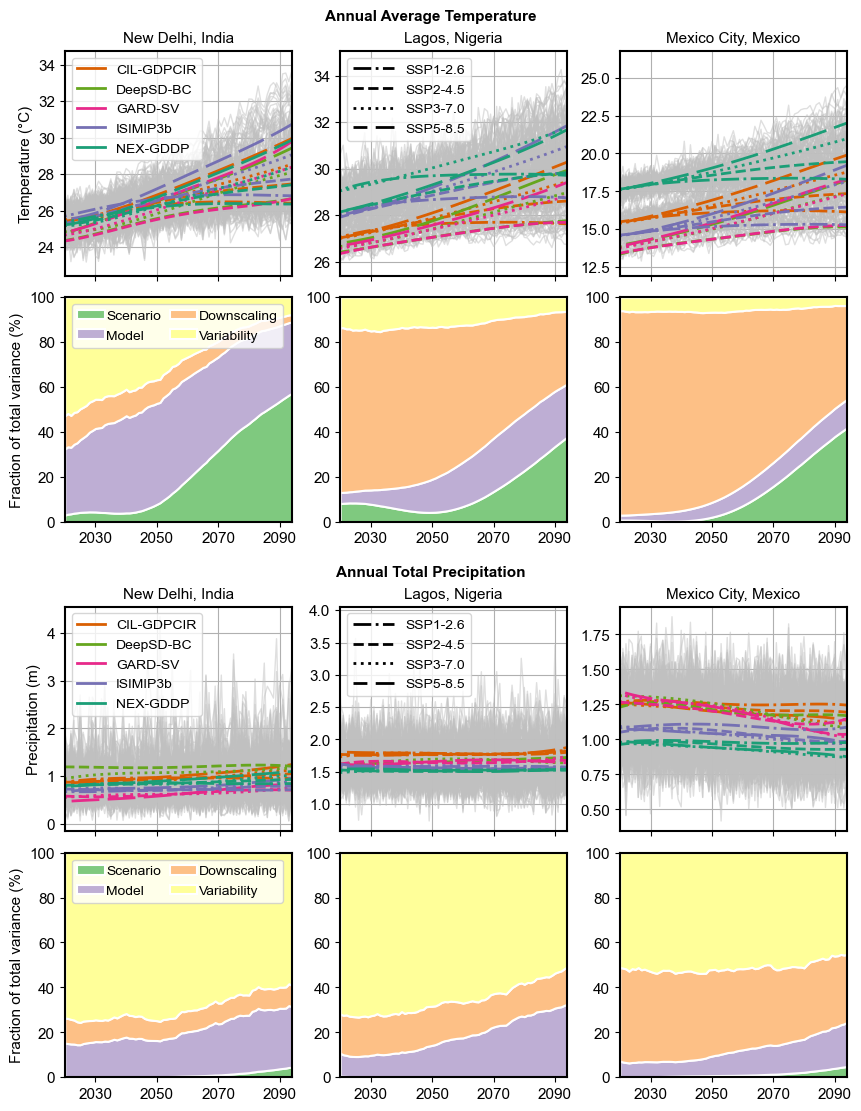

In [16]:
make_figure_1(['delhi', 'lagos', 'mexicocity'],
              ['New Delhi, India', 'Lagos, Nigeria', 'Mexico City, Mexico'],
              ['avg', 'avg'], ['tas', 'pr'],
              'hs09', False,
              ['Annual Average Temperature', 'Annual Total Precipitation'], 
              ['Temperature ' + u'(\N{DEGREE SIGN}C)', 'Precipitation (m)'],
              4,
              'Figure1')

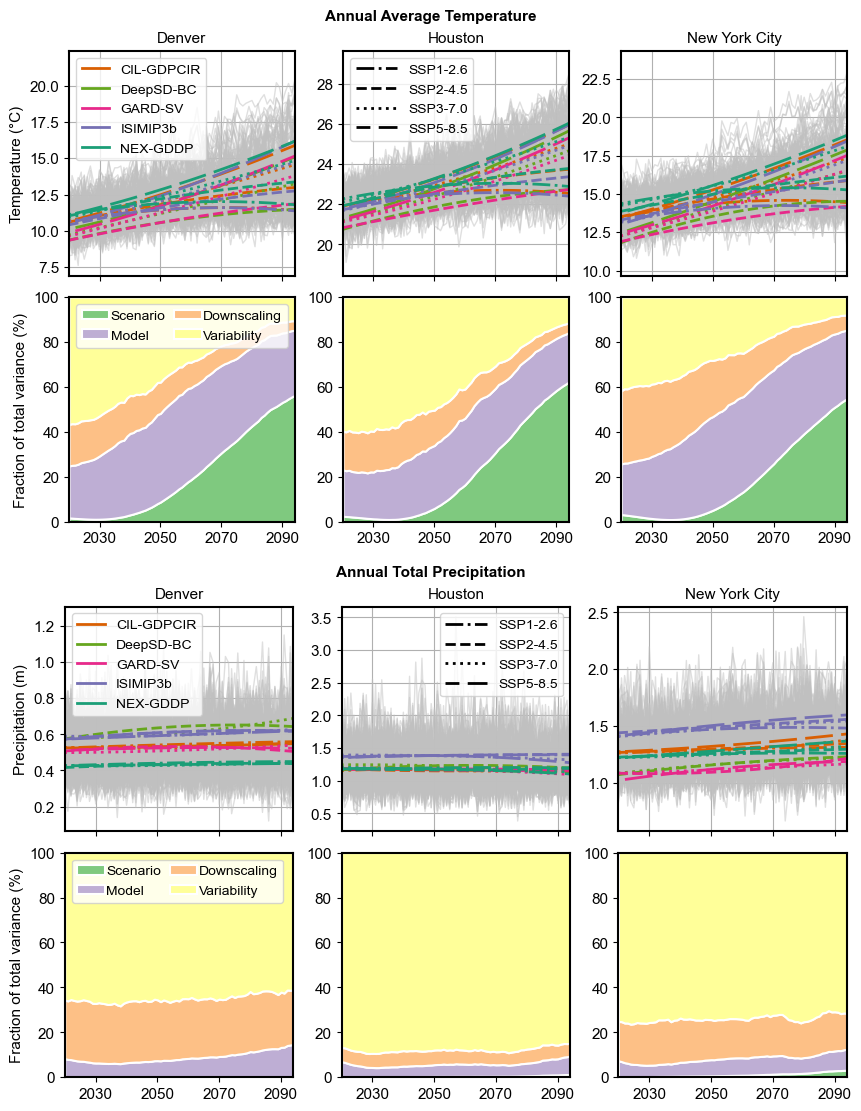

In [17]:
make_figure_1(['denver', 'houston', 'nyc'],
              ['Denver', 'Houston', 'New York City'],
              ['avg', 'avg'], ['tas', 'pr'],
              'hs09', False,
              ['Annual Average Temperature', 'Annual Total Precipitation'], 
              ['Temperature ' + u'(\N{DEGREE SIGN}C)', 'Precipitation (m)'],
              2,
              'avgs_US_cities_1')

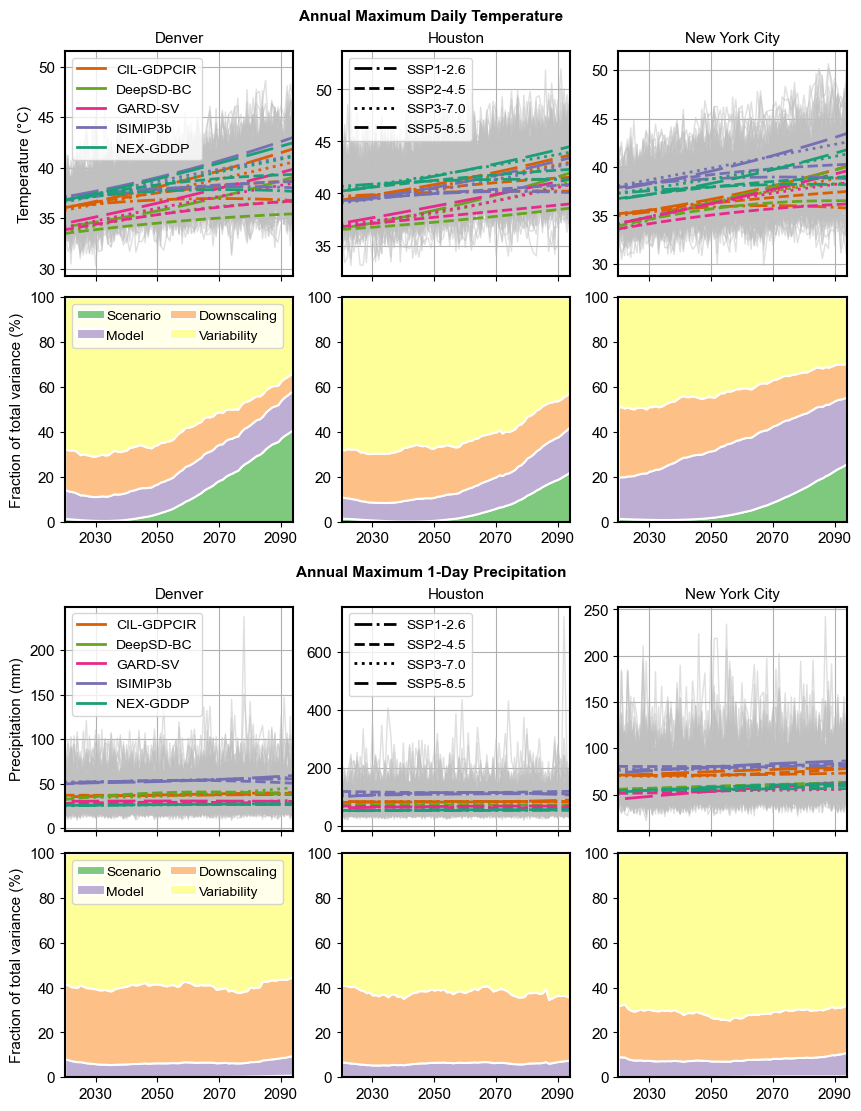

In [18]:
make_figure_1(['denver', 'houston', 'nyc'],
              ['Denver', 'Houston', 'New York City'],
              ['max', 'max'], ['tasmax', 'pr'],
              'hs09', False,
              ['Annual Maximum Daily Temperature', 'Annual Maximum 1-Day Precipitation'], 
              ['Temperature ' + u'(\N{DEGREE SIGN}C)', 'Precipitation (mm)'],
              2,
              'maxs_US_cities_1')

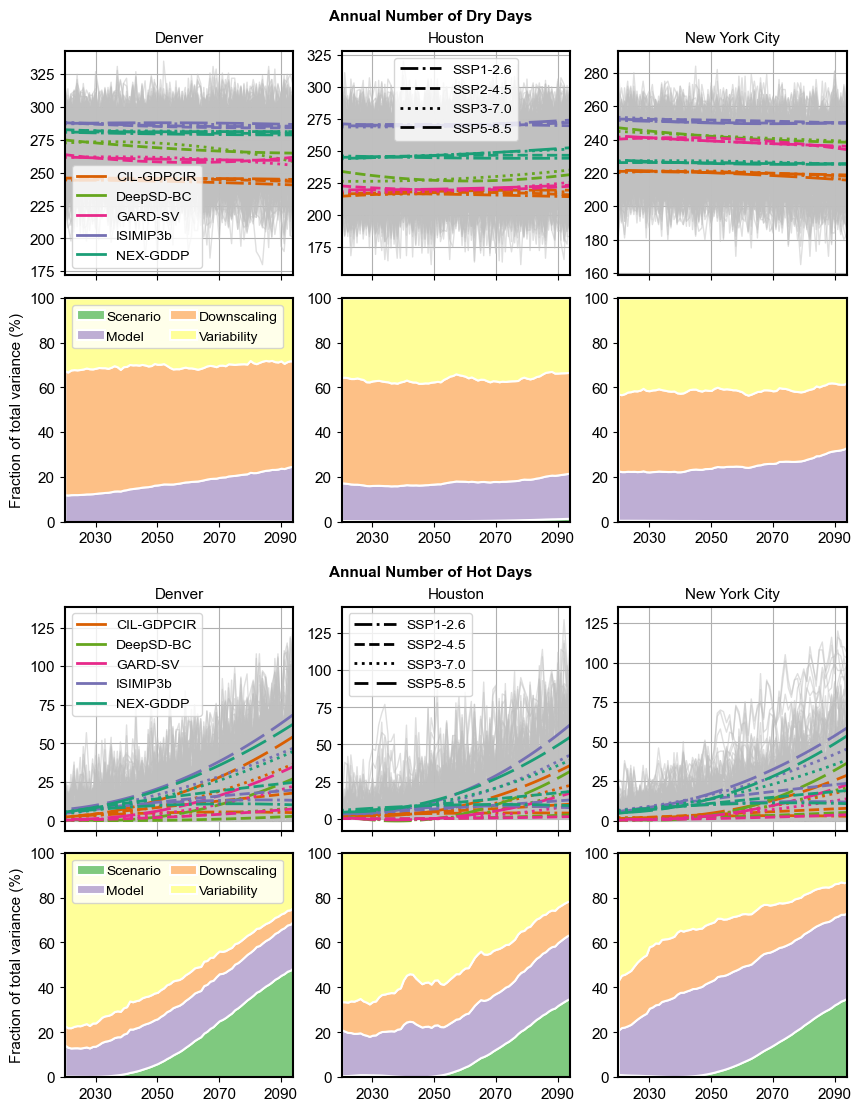

In [19]:
make_figure_1(['denver', 'houston', 'nyc'],
              ['Denver', 'Houston', 'New York City'],
              ['dry', 'hot'], ['count_lt_1', 'tasmax_q99gmfd_count'],
              'hs09', False,
              ['Annual Number of Dry Days', 'Annual Number of Hot Days'], 
              ['', ''],
              2,
              'hot_dry_days_US_cities')

# Figure 2

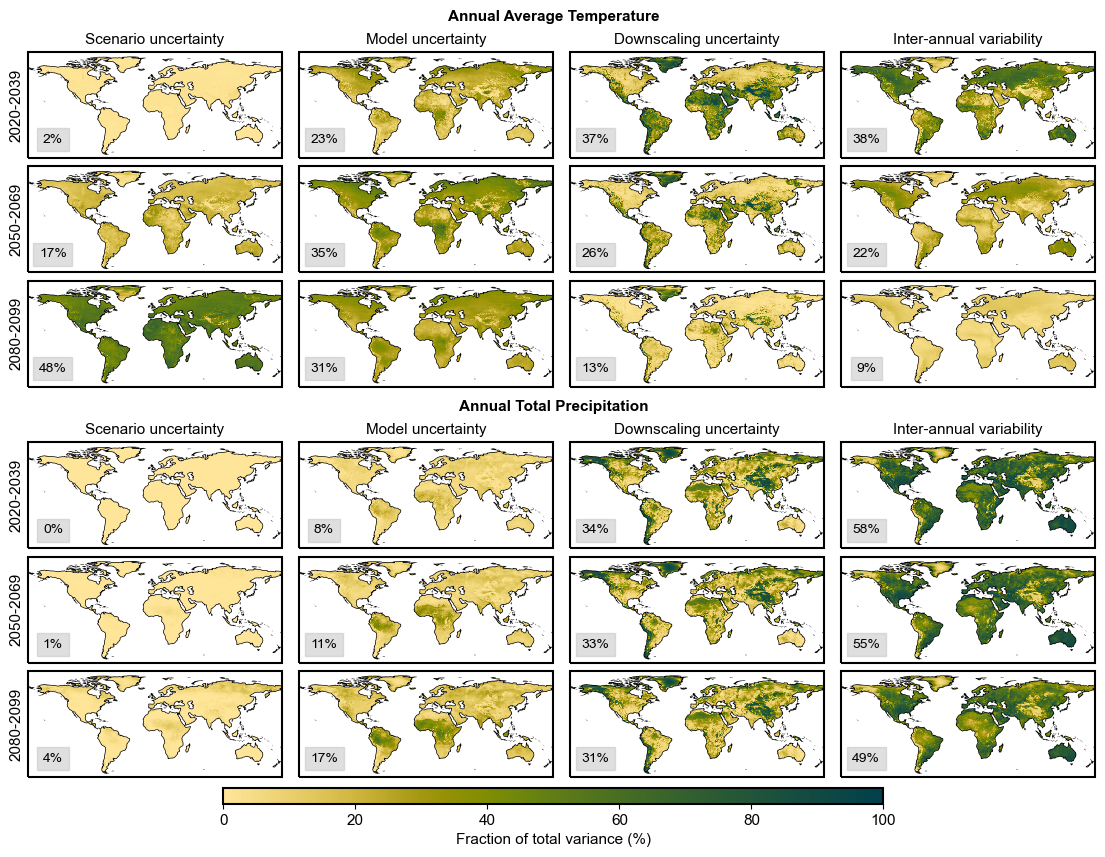

In [25]:
#################
#################
# Figure 2

plt.rcParams['font.size'] = 11
deg = 2
scenario_id = 'hs09'

#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20,20,1])

############################
# Annual average tas
############################
axs = subfigs[0].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[0].suptitle('Annual Average Temperature', fontweight='bold', fontsize=11)

metric = 'avg'
var_id = 'tas'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=False,
         deg=deg,
         scenario_id=scenario_id,
         axs=axs, fig=subfigs[0],
         cbar=False, title=False)

############################
# Annual average pr
############################
axs = subfigs[1].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[1].suptitle('Annual Total Precipitation', fontweight='bold', fontsize=11)

metric = 'avg'
var_id = 'pr'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=False,
         deg=deg,
         scenario_id=scenario_id,
         axs=axs, fig=subfigs[1],
         cbar=False, title=False)

################
# Colorbar
################
cmap= bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100) 
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm) 

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(sm, cax=cbar_ax,
                    orientation='horizontal',
                    label='Fraction of total variance (%)')

plt.savefig('../figs/Figure2.png', dpi=600, bbox_inches="tight")
# plt.show()

# Figure 3

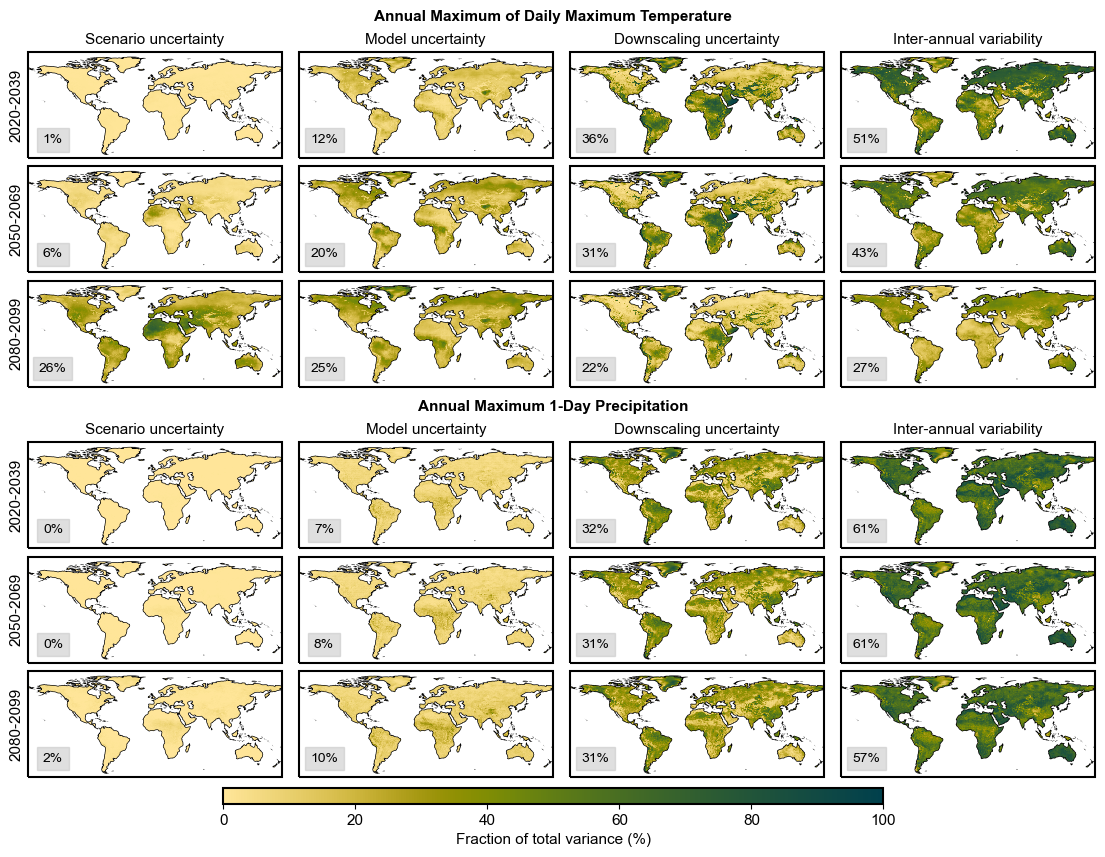

In [26]:
#################
#################
# Figure 3

plt.rcParams['font.size'] = 11
deg = 2
scenario_id = 'hs09'

#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20,20,1])

############################
# Annual average tas
############################
axs = subfigs[0].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[0].suptitle('Annual Maximum of Daily Maximum Temperature', fontweight='bold', fontsize=11)

metric = 'max'
var_id = 'tasmax'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=False,
         deg=deg,
         scenario_id=scenario_id,
         axs=axs, fig=subfigs[0],
         cbar=False, title=False)

############################
# Annual average pr
############################
axs = subfigs[1].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[1].suptitle('Annual Maximum 1-Day Precipitation', fontweight='bold', fontsize=11)

metric = 'max'
var_id = 'pr'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=False,
         deg=deg,
         scenario_id=scenario_id,
         axs=axs, fig=subfigs[1],
         cbar=False, title=False)

################
# Colorbar
################
cmap= bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100) 
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm) 

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(sm, cax=cbar_ax,
                    orientation='horizontal',
                    label='Fraction of total variance (%)')

plt.savefig('../figs/Figure3.png', dpi=600, bbox_inches="tight")
# plt.show()

# Figure 4

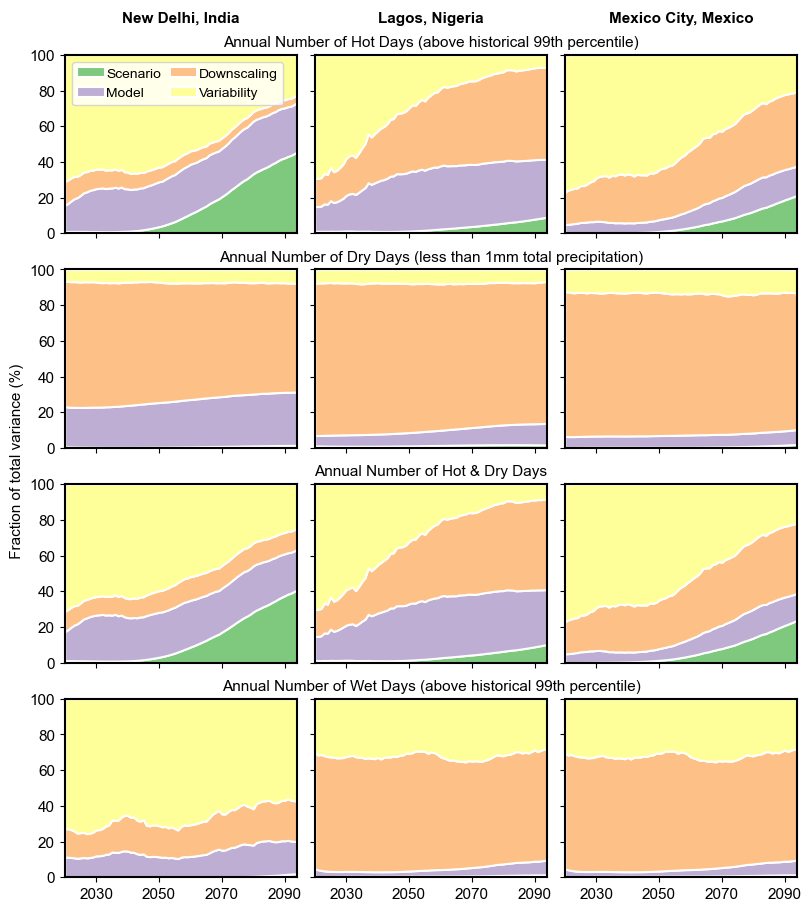

In [36]:
fig, axs = plt.subplots(5, 3, figsize=(8, 9), constrained_layout=True, sharey=True, sharex=True, gridspec_kw={'height_ratios':[1,10,10,10,10]})

# Setup
deg = 4
scenario_id = 'hs09'
const_iav = False

# Cities
city1 = 'delhi'
city2 = 'lagos'
city3 = 'mexicocity'

# Labels
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

axs[0,0].text(0.5 * (left + right), 0.5 * (bottom + top), 'New Delhi, India',
             horizontalalignment='center',
             verticalalignment='center',
             transform=axs[0,0].transAxes,
             fontweight='bold')
axs[0,0].axis('off')

axs[0,1].text(0.5 * (left + right), 0.5 * (bottom + top), 'Lagos, Nigeria',
             horizontalalignment='center',
             verticalalignment='center',
             transform=axs[0,1].transAxes,
              fontweight='bold')
axs[0,1].axis('off')

axs[0,2].text(0.5 * (left + right), 0.5 * (bottom + top), 'Mexico City, Mexico',
             horizontalalignment='center',
             verticalalignment='center',
             transform=axs[0,2].transAxes,
             fontweight='bold')
axs[0,2].axis('off')

# Hot days: count
plot_uc_timeseries('hot', 'tasmax_q99gmfd_count', city_list[city1], deg, scenario_id, const_iav, '', '', '', True, axs[1,0])
axs[1,0].set_yticks([0,20,40,60,80,100])
plot_uc_timeseries('hot', 'tasmax_q99gmfd_count', city_list[city2], deg, scenario_id, const_iav, 'Annual Number of Hot Days (above historical 99th percentile)', '', '', False, axs[1,1])
plot_uc_timeseries('hot', 'tasmax_q99gmfd_count', city_list[city3], deg, scenario_id, const_iav, '', '', '', False, axs[1,2])

# Dry days: count
plot_uc_timeseries('dry', 'count_lt_1', city_list[city1], deg, scenario_id, const_iav, '', '', '', False, axs[2,0])
plot_uc_timeseries('dry', 'count_lt_1', city_list[city2], deg, scenario_id, const_iav, 'Annual Number of Dry Days (less than 1mm total precipitation)', '', '', False, axs[2,1])
plot_uc_timeseries('dry', 'count_lt_1', city_list[city3], deg, scenario_id, const_iav, '', '', '', False, axs[2,2])

# Hot & Dry days: count
plot_uc_timeseries('hotdry', 'hotdry_q99gmfd_count', city_list[city1], deg, scenario_id, const_iav, '',
                   '\t\t\t\t\t\t\t\t\t\t\t\t\t Fraction of total variance (%)'.replace('\t', '    '), '', False, axs[3,0])
plot_uc_timeseries('hotdry', 'hotdry_q99gmfd_count', city_list[city2], deg, scenario_id, const_iav, 'Annual Number of Hot & Dry Days', '', '', False, axs[3,1])
plot_uc_timeseries('hotdry', 'hotdry_q99gmfd_count', city_list[city3], deg, scenario_id, const_iav, '', '', '', False, axs[3,2])

# Wet days: count
plot_uc_timeseries('wet', 'pr_q99gmfd_count', city_list[city1], deg, scenario_id, const_iav, '', '', '', False, axs[4,0])
plot_uc_timeseries('wet', 'pr_q99gmfd_count', city_list[city2], deg, scenario_id, const_iav, 'Annual Number of Wet Days (above historical 99th percentile)', '', '', False, axs[4,1])
plot_uc_timeseries('wet', 'pr_q99gmfd_count', city_list[city2], deg, scenario_id, const_iav, '', '', '', False, axs[4,2])

In [53]:
# fig, axs = plt.subplots(4, 4, figsize=(10, 8), constrained_layout=True, sharey=True, sharex=True)

# # Setup
# deg = 4
# scenario_id = 'hs09'
# const_iav = False

# # Cities
# city1 = 'delhi'
# city2 = 'lagos'

# # Hot days: count
# plot_uc_timeseries('hot', 'tasmax_q99gmfd_count', city_list[city1], deg, scenario_id, const_iav, 'Annual Number of Hot Days (above historical 99th percentile)', '', '', True, axs[0,0])
# plot_uc_timeseries('hot', 'tasmax_q99gmfd_count', city_list[city2], deg, scenario_id, const_iav, '', '', '', False, axs[0,1])

# # Hot days: streak
# plot_uc_timeseries('hot', 'tasmax_q99gmfd_streak', city_list[city1], deg, scenario_id, const_iav, 'Longest Consecutive Number of Hot Days', '', '', False, axs[0,2])
# plot_uc_timeseries('hot', 'tasmax_q99gmfd_streak', city_list[city2], deg, scenario_id, const_iav, '', '', '', False, axs[0,3])

# # Dry days: count
# plot_uc_timeseries('dry', 'count_lt_1', city_list[city1], deg, scenario_id, const_iav, 'Annual Number of Dry Days (less than 1mm total precipitation)', '', '', False, axs[1,0])
# plot_uc_timeseries('dry', 'count_lt_1', city_list[city2], deg, scenario_id, const_iav, '', '', '', False, axs[1,1])

# # Dry days: streak
# plot_uc_timeseries('dry', 'streak_lt_1', city_list[city1], deg, scenario_id, const_iav, 'Longest Consecutive Number of Dry Days', '', '', False, axs[1,2])
# plot_uc_timeseries('dry', 'streak_lt_1', city_list[city2], deg, scenario_id, const_iav, '', '', '', False, axs[1,3])

# # Hot & Dry days: count
# plot_uc_timeseries('hotdry', 'hotdry_q99gmfd_count', city_list[city1], deg, scenario_id, const_iav, 'Annual Number of Hot & Dry Days', '', '', False, axs[2,0])
# plot_uc_timeseries('hotdry', 'hotdry_q99gmfd_count', city_list[city2], deg, scenario_id, const_iav, '', '', '', False, axs[2,1])

# # Hot & Dry days: streak
# plot_uc_timeseries('hotdry', 'hotdry_q99gmfd_streak', city_list[city1], deg, scenario_id, const_iav, 'Longest Consecutive Number of Hot & Dry Days', '', '', False, axs[2,2])
# plot_uc_timeseries('hotdry', 'hotdry_q99gmfd_streak', city_list[city2], deg, scenario_id, const_iav, '', '', '', False, axs[2,3])

# # Wet days: count
# plot_uc_timeseries('wet', 'pr_q99gmfd_count', city_list[city1], deg, scenario_id, const_iav, 'Annual Number of Wet Days (above historical 99th percentile)', '', '', False, axs[3,0])
# plot_uc_timeseries('wet', 'pr_q99gmfd_count', city_list[city2], deg, scenario_id, const_iav, '', '', '', False, axs[3,1])

# # Wet days: streak
# plot_uc_timeseries('wet', 'pr_q99gmfd_streak', city_list[city1], deg, scenario_id, const_iav, 'Longest Consecutive Number of Wet Days', '', '', False, axs[3,2])
# plot_uc_timeseries('wet', 'pr_q99gmfd_streak', city_list[city2], deg, scenario_id, const_iav, '', '', '', False, axs[3,3])

In [158]:
# # Plot IPCC AR6 regions
# def plot_ar6_regions(regions, ax):
#     text_kws = dict(color="#67000d", fontsize=10, bbox=dict(pad=0.2, color="w"))
    
#     regionmask.defined_regions.ar6.land[regions].plot(
#         text_kws=text_kws,
#         add_ocean=True,
#         label='abbrev',
#         ax=ax
#     )

#     ax.add_feature(cfeature.BORDERS, edgecolor='gray')
#     ax.set_extent([-150, -45, 5, 65])

In [52]:
# projLam = ccrs.LambertConformal()
# projPC = ccrs.PlateCarree()

# fig, ax = plt.subplots(1, 1, subplot_kw={'projection':projLam})


# ax.add_patch(mpatches.Rectangle(xy = [-120, 33], width=6, height=5,
#                                 facecolor='orange',
#                                 alpha=0.5,
#                                 label='Southern California',
#                                 transform=projPC))

# ax.add_patch(mpatches.Rectangle(xy = [-96.5, 36.5], width=9, height=7,
#                                 facecolor='green',
#                                 alpha=0.5,
#                                 label='Midwest',
#                                 transform=projPC))
    
# states_provinces = cfeature.NaturalEarthFeature(
#     category='cultural',
#     name='admin_1_states_provinces_lakes',
#     scale='50m',
#     facecolor='none')

# ax.add_feature(states_provinces, edgecolor='black')
# ax.coastlines(resolution='50m', color='black')

# ax.set_extent([-125, -65, 22, 52], crs=projPC)
# plt.legend(loc='lower left', ncols=2)
# plt.show()

# Figure 5

In [160]:
def make_figure_5(df, timeperiod, var_id, xlabel, ylabel, ens_legend, ssp_legend, fig):
    axs = fig.subplots(2, 1, sharex=True,
                       gridspec_kw={'hspace':0.0, 'wspace':0.1, 'height_ratios':[2.5,1]})

    # Drop ensembles
    df = df[~df.ensemble.isin(['DeepSD-BC', 'GARD-SV'])]
    
    # Select time period
    if timeperiod == 'mid':
        df_plot = df.query('time >= 2050 and time <= 2069')
    elif timeperiod == 'late':
        df_plot = df.query('time >= 2070 and time <= 2099')
        
    # Plot aesthetics
    ens_color_dict = {'NEX': '#1b9e77', 'CIL':'#d95f02', 'ISIMIP':'#7570b3'} #, 'GARD-SV':'#e7298a', 'DeepSD-BC':'#66a61e'}
    ens_label_dict = {'NEX': 'NEX-GDDP', 'CIL':'CIL-GDPCIR', 'ISIMIP':'ISIMIP3b'}
    ssp_line_dict = {'ssp585':(5, (10, 3)), 'ssp370':'dotted', 'ssp245':'dashed', 'ssp126':'dashdot'}
    ssp_label_dict = {'ssp585':'SSP5-8.5', 'ssp370':'SSP3-7.0', 'ssp245':'SSP2-4.5', 'ssp126':'SSP1-2.6'}
    
    lw = 2
    boxw = 0.4 # boxplot width
    
    ssps = ssp_line_dict.keys()
    enss = ens_color_dict.keys()
    
    ################
    ## Boxplots
    ################
    ax=axs[1]
    
    # SSPs
    for idx, ssp in enumerate(ssps):
        boxplot = ax.boxplot(df_plot[df_plot.ssp == ssp][var_id].to_numpy(),
                             vert=False, positions=[idx],
                             patch_artist=True,
                             medianprops=dict(linewidth=lw-0.5, color='gray'),
                             boxprops=dict(linewidth=lw-0.5, color='gray'),
                             whiskerprops=dict(linewidth=lw-0.5, color='gray', ls=ssp_line_dict[ssp]),
                             capprops=dict(linewidth=lw-0.5, color='gray'),
                             whis=(0.5,99.5),
                             showfliers=False,
                             widths=boxw)
        
        for patch in boxplot['boxes']:
            patch.set_facecolor('white')
    
    # Ensembles
    for idx, ens in enumerate(enss):
        boxplot = ax.boxplot(df_plot[df_plot.ensemble == ens][var_id].to_numpy(),
                             vert=False, positions=[len(ssp_line_dict.keys()) + idx],
                             patch_artist=True,
                             medianprops=dict(linewidth=lw-0.5, color='black'),
                             boxprops=dict(linewidth=lw-0.5, color=ens_color_dict[ens]),
                             whiskerprops=dict(linewidth=lw-0.5, color=ens_color_dict[ens]),
                             capprops=dict(linewidth=lw-0.5, color=ens_color_dict[ens]),
                             whis=(0.5,99.5),
                             showfliers=False,
                             widths=boxw)
        
        for patch in boxplot['boxes']:
            patch.set_facecolor(ens_color_dict[ens])
    
    # Full        
    boxplot = ax.boxplot(df_plot[var_id].to_numpy(),
                         vert=False, positions=[len(ssp_line_dict.keys()) + len(ens_color_dict.keys())],
                         patch_artist=True,
                         medianprops=dict(linewidth=lw-0.5, color='white'),
                         boxprops=dict(linewidth=lw-0.5, color='black'),
                         whiskerprops=dict(linewidth=lw-0.5, color='black'),
                         capprops=dict(linewidth=lw-0.5, color='black'),
                         whis=(0.5,99.5),
                         showfliers=False,
                         widths=boxw)
        
    for patch in boxplot['boxes']:
        patch.set_facecolor('black')
        
    # Axes
    ax.set_xlabel(xlabel)
    ax.set_xlim(ax.get_xlim())
    ax.set_yticklabels('')
    ax.set_yticks([])
    ax.spines[['right', 'top', 'left']].set_visible(False)
    
    #################
    ### KDE plots
    #################
    ax = axs[0]
    
    # SSPs
    for ssp in ssps:
        df_plot[df_plot.ssp == ssp][var_id].plot.kde(ax=ax,
                                                     color='gray', 
                                                     ls=ssp_line_dict[ssp],
                                                     lw=lw)
    # Ensembles
    for ens in enss:
        df_plot[df_plot.ensemble == ens][var_id].plot.kde(ax=ax,
                                                          color=ens_color_dict[ens], 
                                                          lw=lw)
    
    # Full
    df_plot[var_id].plot.kde(ax=ax,
                             color='black',
                             lw=lw+1)

    if ens_legend:
        custom_lines = [Line2D([0], [0], color='black', lw=lw+1)] + \
        [Line2D([0], [0], color=ens_color_dict[ens], lw=lw) for ens in list(enss)[::-1]]
        ax.legend(custom_lines, ['Full Ensemble'] + [ens_label_dict[ens] for ens in list(enss)[::-1]],
                  handlelength=2)
    if ssp_legend:
        custom_lines = [Line2D([0], [0], color='gray', lw=lw, ls=ssp_line_dict[ssp]) for ssp in ssps]
        ax.legend(custom_lines, [ssp_label_dict[ssp] for ssp in list(ssps)[::-1]],
                  handlelength=3)
    
    ax.grid(alpha=0.5)
    ax.set_ylabel(ylabel)
    ax.set_yticklabels('')
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.tick_params(axis='both', which='both', bottom=False, left=False)

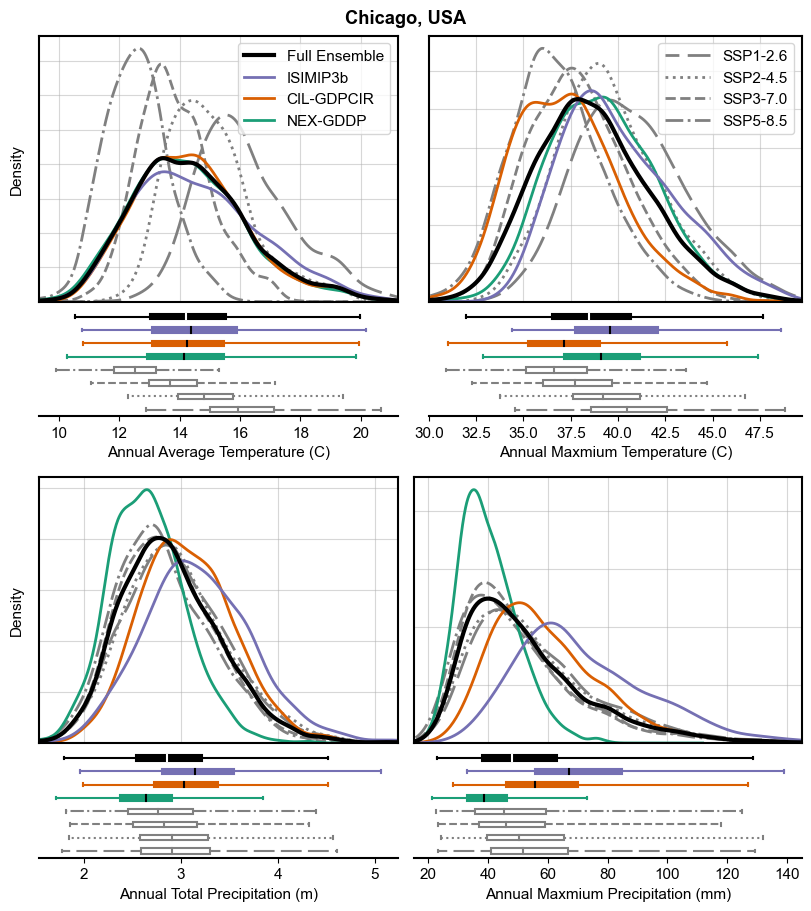

In [164]:
# Plot
plt.rcParams['font.size'] = 11

fig = plt.figure(figsize=(8, 9), constrained_layout=True)
subfigs = fig.subfigures(2, 2)

# Select city
city = 'chicago'
fig.suptitle('Chicago, USA', fontweight='bold')

# Temperature
make_figure_5(pd.read_csv(data_path + city + '_avg_tas.csv'),
              'late', 'tas', 'Annual Average Temperature (C)', 'Density', True, False, subfigs[0,0])
make_figure_5(pd.read_csv(data_path + city + '_max_tasmax.csv'),
              'late', 'tasmax', 'Annual Maxmium Temperature (C)', '', False, True, subfigs[0,1])

# Precip
make_figure_5(pd.read_csv(data_path + city + '_avg_pr.csv'),
              'late', 'pr', 'Annual Total Precipitation (m)', 'Density', False, False, subfigs[1,0])
make_figure_5(pd.read_csv(data_path + city + '_max_pr.csv'),
              'late', 'pr', 'Annual Maxmium Precipitation (mm)', '', False, False, subfigs[1,1])

plt.show()

# Other metrics: map plots

FileNotFoundError: [Errno 2] No such file or directory: b'/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/results/uncertainty_partitioning/max5d_deg2.nc'

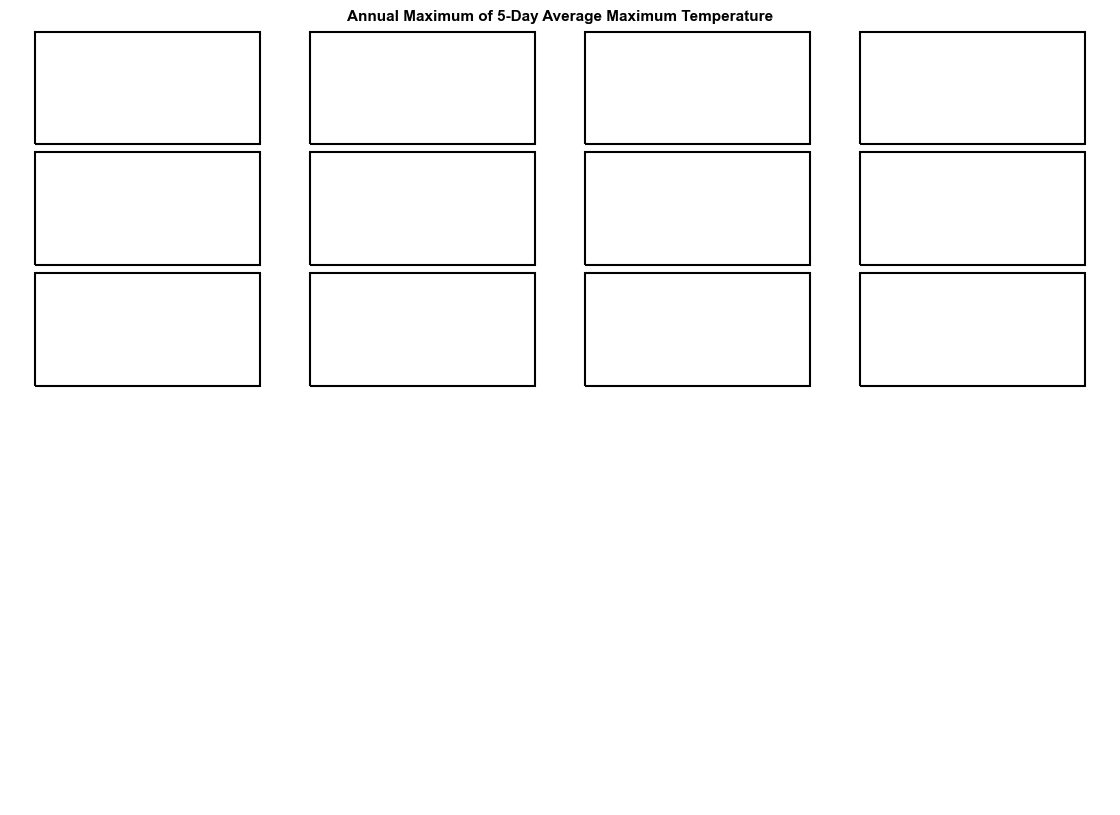

In [24]:
#################
#################
plt.rcParams['font.size'] = 11
deg = 2

#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20,20,1])

############################
# Annual average tas
############################
axs = subfigs[0].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[0].suptitle('Annual Maximum of 5-Day Average Maximum Temperature', fontweight='bold', fontsize=11)

metric = 'max5d'
var_id = 'tasmax'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=True,
         deg=deg,
         scenario_id='hs09',
         axs=axs, fig=subfigs[0],
         cbar=False, title=False)

############################
# Annual average pr
############################
axs = subfigs[1].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[1].suptitle('Annual Maximum 5-Day Precipitation', fontweight='bold', fontsize=11)

metric = 'max5d'
var_id = 'RX5day'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=True,
         deg=deg,
         scenario_id='hs09',
         axs=axs, fig=subfigs[1],
         cbar=False, title=False)

################
# Colorbar
################
cmap= bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100) 
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm) 

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(sm, cax=cbar_ax,
                    orientation='horizontal',
                    label='Fraction of total variance (%)')

plt.savefig('../figs/UC_max5d.png', dpi=600, bbox_inches="tight")
# plt.show()

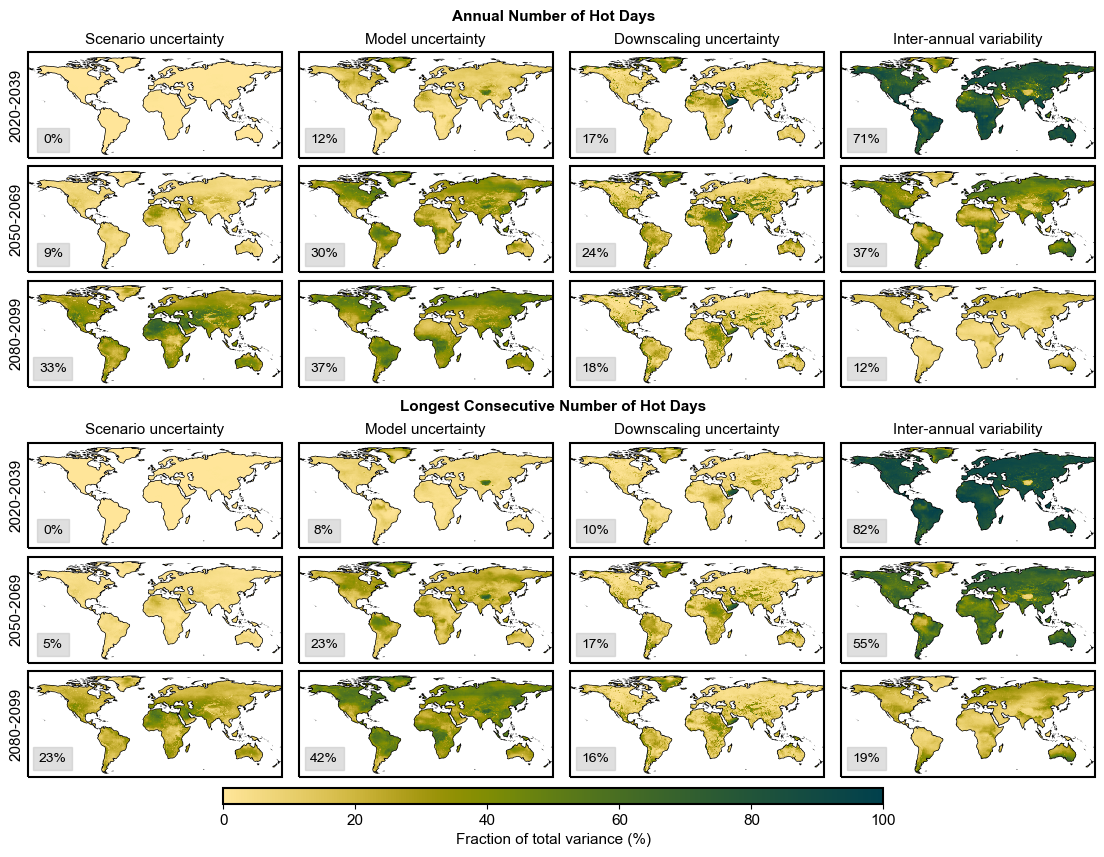

In [25]:
#################
#################
plt.rcParams['font.size'] = 11
deg = 4
#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20,20,1])

axs = subfigs[0].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[0].suptitle('Annual Number of Hot Days', fontweight='bold', fontsize=11)

metric = 'hot'
var_id = 'tasmax_q99gmfd_count'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=True,
         deg=deg,
         scenario_id='hs09',
         axs=axs, fig=subfigs[0],
         cbar=False, title=False)

axs = subfigs[1].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[1].suptitle('Longest Consecutive Number of Hot Days', fontweight='bold', fontsize=11)

metric = 'hot'
var_id = 'tasmax_q99gmfd_streak'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=True,
         deg=deg,
         scenario_id='hs09',
         axs=axs, fig=subfigs[1],
         cbar=False, title=False)

################
# Colorbar
################
cmap= bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100) 
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm) 

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(sm, cax=cbar_ax,
                    orientation='horizontal',
                    label='Fraction of total variance (%)')

plt.savefig('../figs/UC_hot_days.png', dpi=600, bbox_inches="tight")
# plt.show()

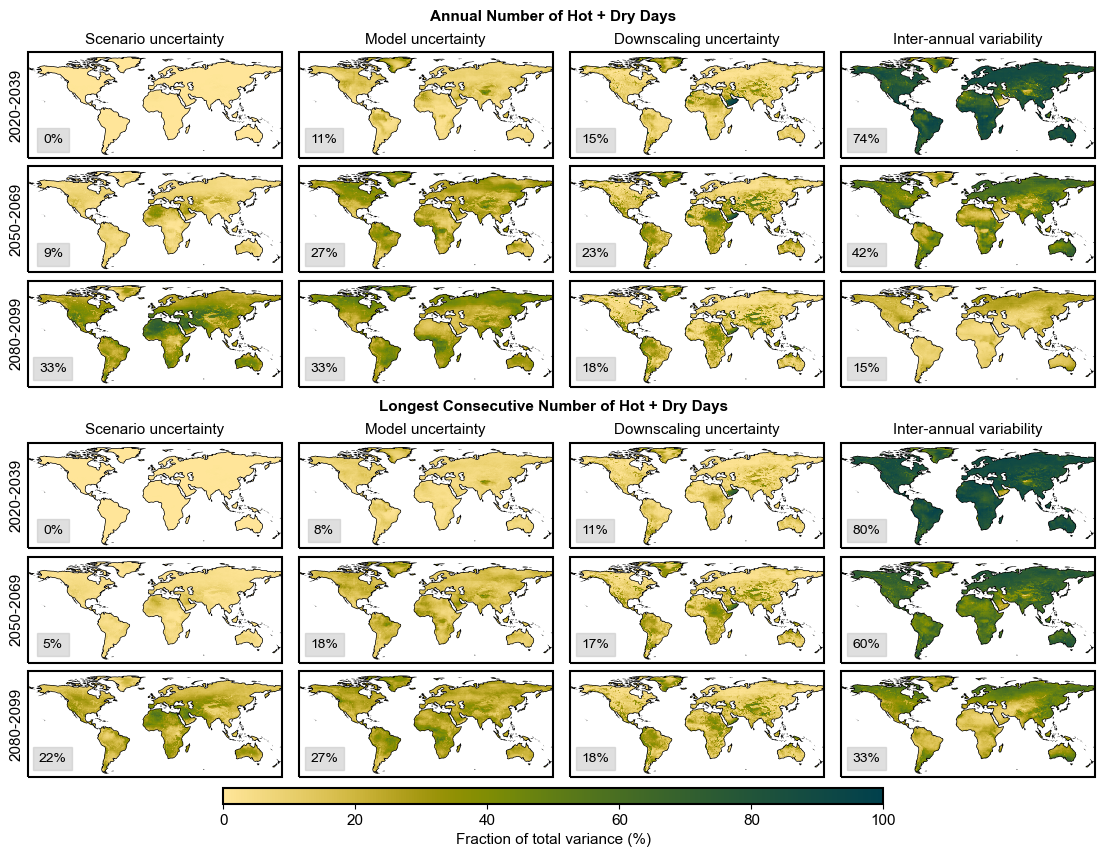

In [26]:
#################
#################
# Hot + Dry

plt.rcParams['font.size'] = 11
deg = 4

#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20,20,1])

axs = subfigs[0].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[0].suptitle('Annual Number of Hot + Dry Days', fontweight='bold', fontsize=11)

metric = 'hotdry'
var_id = 'hotdry_q99gmfd_count'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=True,
         deg=deg,
         scenario_id='hs09',
         axs=axs, fig=subfigs[0],
         cbar=False, title=False)

axs = subfigs[1].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[1].suptitle('Longest Consecutive Number of Hot + Dry Days', fontweight='bold', fontsize=11)

metric = 'hotdry'
var_id = 'hotdry_q99gmfd_streak'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=True,
         deg=deg,
         scenario_id='hs09',
         axs=axs, fig=subfigs[1],
         cbar=False, title=False)

################
# Colorbar
################
cmap= bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100) 
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm) 

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(sm, cax=cbar_ax,
                    orientation='horizontal',
                    label='Fraction of total variance (%)')

plt.savefig('../figs/UC_hotdry_days.png', dpi=600, bbox_inches="tight")
# plt.show()

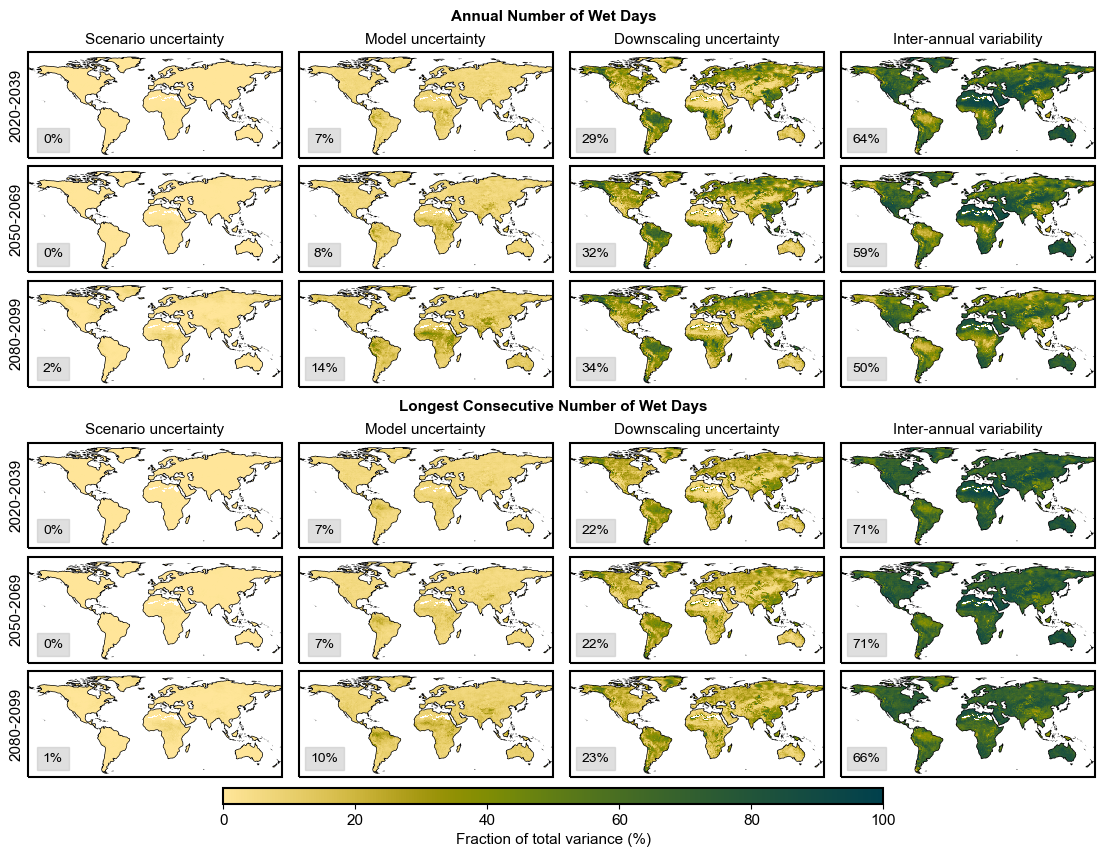

In [29]:
#################
#################
# Wet days

plt.rcParams['font.size'] = 11
deg = 4
#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20,20,1])

axs = subfigs[0].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[0].suptitle('Annual Number of Wet Days', fontweight='bold', fontsize=11)

metric = 'wet'
var_id = 'pr_q99gmfd_count'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=True,
         deg=deg,
         scenario_id='hs09',
         axs=axs, fig=subfigs[0],
         cbar=False, title=False)

axs = subfigs[1].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[1].suptitle('Longest Consecutive Number of Wet Days', fontweight='bold', fontsize=11)

metric = 'wet'
var_id = 'pr_q99gmfd_streak'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=True,
         deg=deg,
         scenario_id='hs09',
         axs=axs, fig=subfigs[1],
         cbar=False, title=False)

################
# Colorbar
################
cmap= bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100) 
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm) 

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(sm, cax=cbar_ax,
                    orientation='horizontal',
                    label='Fraction of total variance (%)')

plt.savefig('../figs/UC_wet_days.png', dpi=600, bbox_inches="tight")
plt.show()

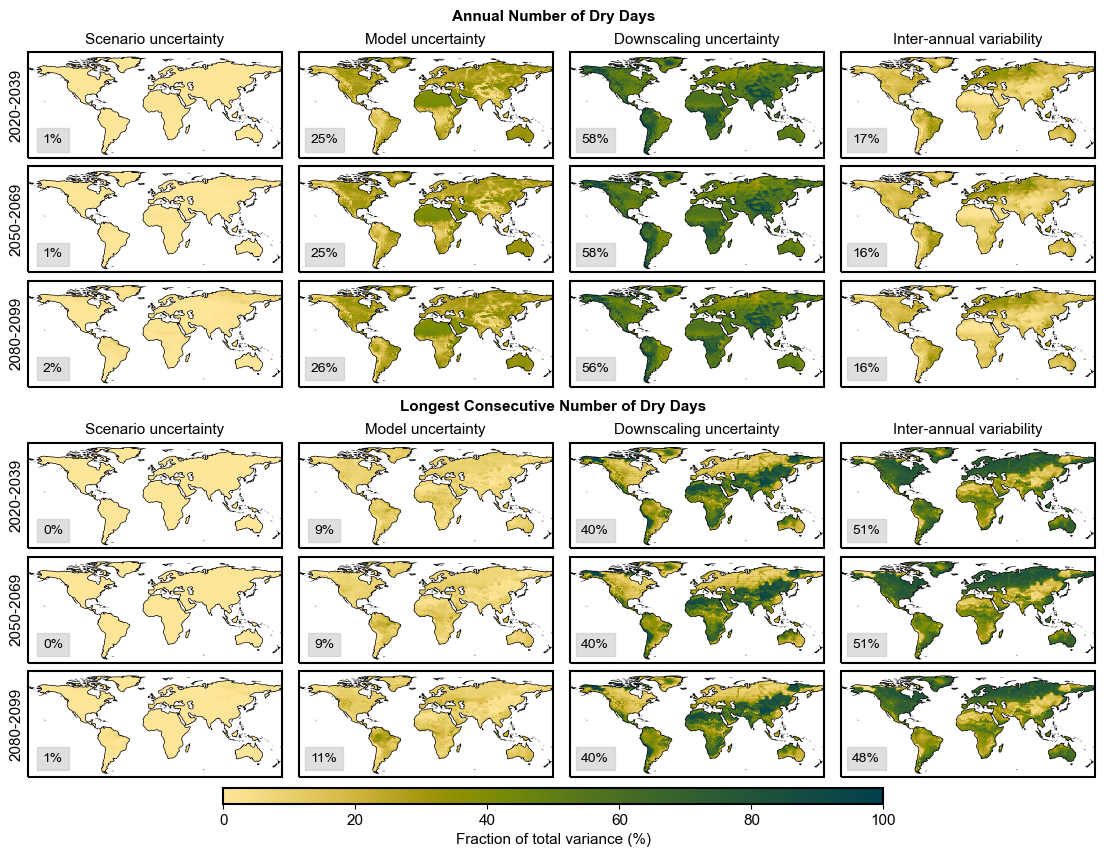

In [28]:
#################
#################
# Dry days

plt.rcParams['font.size'] = 11
deg = 4

#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20,20,1])

axs = subfigs[0].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[0].suptitle('Annual Number of Dry Days', fontweight='bold', fontsize=11)

metric = 'dry'
var_id = 'count_lt_1'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=True,
         deg=deg,
         scenario_id='hs09',
         axs=axs, fig=subfigs[0],
         cbar=False, title=False)

axs = subfigs[1].subplots(3, 4, subplot_kw={'projection':ccrs.PlateCarree()})
subfigs[1].suptitle('Longest Consecutive Number of Dry Days', fontweight='bold', fontsize=11)

metric = 'dry'
var_id = 'streak_lt_1'

plot_uc_map(metric=metric, var_id=var_id, 
         const_iav=True,
         deg=deg,
         scenario_id='hs09',
         axs=axs, fig=subfigs[1],
         cbar=False, title=False)

################
# Colorbar
################
cmap= bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100) 
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm) 

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(sm, cax=cbar_ax,
                    orientation='horizontal',
                    label='Fraction of total variance (%)')

plt.savefig('../figs/UC_dry_days.png', dpi=600, bbox_inches="tight")
# plt.show()

# Other metrics: regional plots

In [ ]:
##############################
# Regional UC timeseries
# (for hot_spatial)
##############################
def plot_uc_timeseries_region(metric, submetric, var_id, region, deg, scenario_id, title, ylabel, xlabel, legend, ax):
    """
    Region must be IPCC AR6 region name. IAV must be assumed constant.
    """
    # Setup read paths
    uc_read_path = path_in + 'uncertainty_partitioning/' + metric + '_' + submetric + '_deg' + str(deg) + '_noISIMIP.csv'
    iav_read_path = path_in + 'uncertainty_partitioning/' + metric + '_' + submetric + '_deg' + str(deg) + '_const_iav_noISIMIP.csv'
    
    # Read
    df_uc = pd.read_csv(uc_read_path)
    df_iav = pd.read_csv(iav_read_path)
    df_iav['uncertainty'] = 'variability'
        
    # Select region
    df_uc_region = df_uc[df_uc.region == region]
    df_iav_region = df_iav[df_iav.region == region]
    
    # Add year index for IAV
    df_iav_region = pd.concat([df_iav_region]*85)
    df_iav_region['year'] = np.arange(2015, 2100)
    
    # Merge
    df_region = pd.concat([df_iav_region, df_uc_region])
    
    # Select var_id
    df_region = df_region[['year', 'uncertainty', var_id]]
    
    # Select correct uncertainties
    scenario = 'scenario_' + scenario_id
    df_region = df_region[df_region.uncertainty.isin(['ensemble', 'model', scenario, 'variability'])]
    
    # Get 'total' uncertainty
    U_total = df_region.groupby('year').sum(numeric_only=True).reset_index()
    
    # Model uncertainty
    U_model = df_region[df_region.uncertainty == 'model'].drop(columns='uncertainty')
    U_model = pd.merge(U_model, U_total, on='year', suffixes=('_model', '_total'))
    U_model['U_model'] = 100 * U_model[var_id + '_model'] / U_model[var_id + '_total']

    # Downscaling uncertainty
    U_ens = df_region[df_region.uncertainty == 'ensemble'].drop(columns='uncertainty')
    U_ens = pd.merge(U_ens, U_total, on='year', suffixes=('_ensemble', '_total'))
    U_ens['U_ens'] = 100 * U_ens[var_id + '_ensemble'] / U_ens[var_id + '_total']
    
    # Scenario uncertainty
    U_scen = df_region[df_region.uncertainty == scenario].drop(columns='uncertainty')
    U_scen = pd.merge(U_scen, U_total, on='year', suffixes=('_scen', '_total'))
    U_scen['U_scen'] = 100 * U_scen[var_id + '_scen'] / U_scen[var_id + '_total']
    
    # Interannual variability
    U_iav = df_region[df_region.uncertainty == 'variability'].drop(columns='uncertainty')
    U_iav = pd.merge(U_iav, U_total, on='year', suffixes=('_iav', '_total'))
    U_iav['U_iav'] = 100 * U_iav[var_id + '_iav'] / U_iav[var_id + '_total']
    
    # Construct plotting dict
    uncert_dict = {
    'Scenario': U_scen.sort_values(by='year')['U_scen'].to_numpy(),
    'Model': U_model.sort_values(by='year')['U_model'].to_numpy(),
    'Downscaling': U_ens.sort_values(by='year')['U_ens'].to_numpy(),
    'Variability': U_iav.sort_values(by='year')['U_iav'].to_numpy()
    }
        
    # Make plot
    ax.stackplot(np.arange(2015, 2100),
                 uncert_dict.values(),
                 labels=uncert_dict.keys(),
                 alpha=1, colors=['#7fc97f', '#beaed4', '#fdc086', '#ffff99'],
                 edgecolor='white',
                 lw=1.5)

    if legend:
        ax.legend(loc='upper left', ncol=2, columnspacing=1, handletextpad=0.1, fontsize=10)
    ax.set_ylim([0,100])
    ax.set_xlim([2015,2099])
    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontsize=11)

In [23]:
# Plot IPCC AR6 regions
def plot_ar6_regions(regions, ax):
    text_kws = dict(color="#67000d", fontsize=10, bbox=dict(pad=0.2, color="w"))
    
    regionmask.defined_regions.ar6.land[regions].plot(
        text_kws=text_kws,
        add_ocean=True,
        label='abbrev',
        ax=ax
    )

    ax.add_feature(cfeature.BORDERS, edgecolor='gray')
    ax.set_extent([-150, -45, 5, 65])

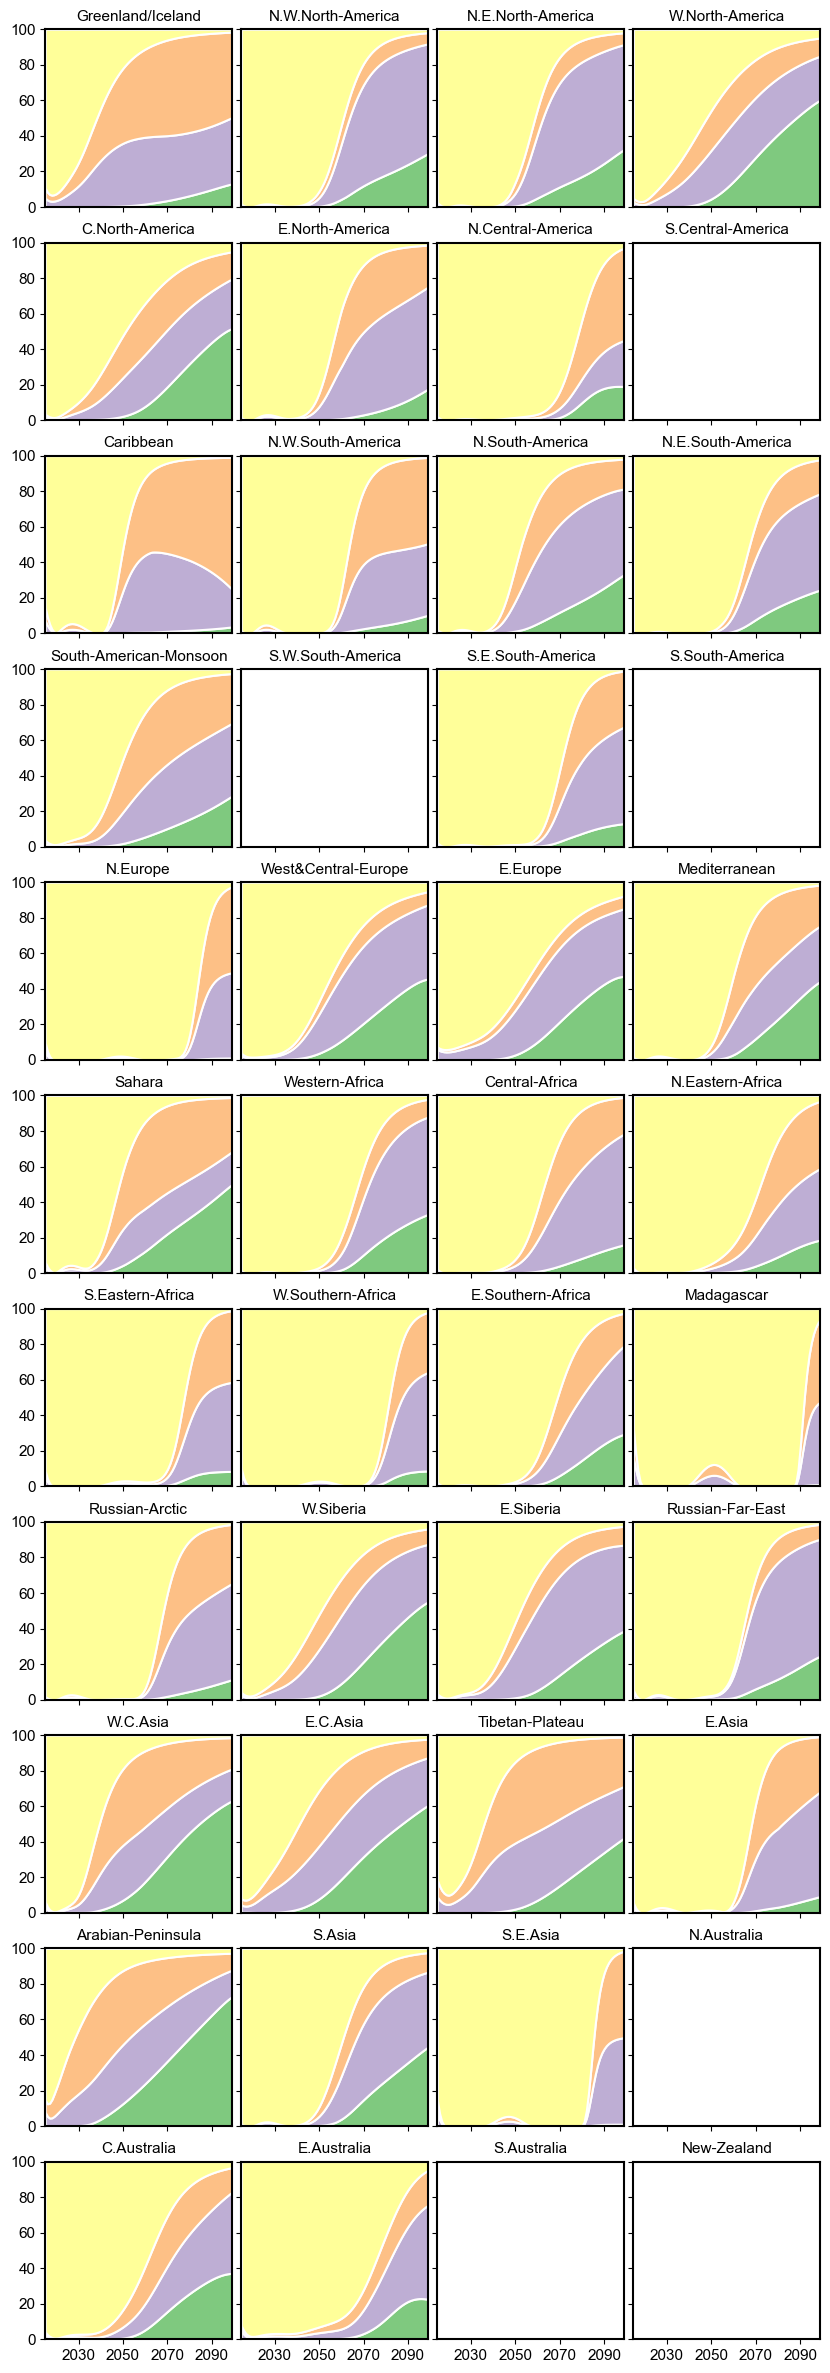

In [97]:
fig, axs = plt.subplots(11, 4, figsize=(10,30), gridspec_kw={'wspace':0.05}, sharex=True, sharey=True)
axs = axs.flatten()

deg = 4

for i, region in enumerate(regionmask.defined_regions.ar6.land.abbrevs[:-2]):
    plot_uc_timeseries_region('hot_spatial', 'tasmax', 'tasmax_q99gmfd_count',
                          region, deg, 'hs09', regionmask.defined_regions.ar6.land.names[i], '', '', False, axs[i])
    
plt.show()

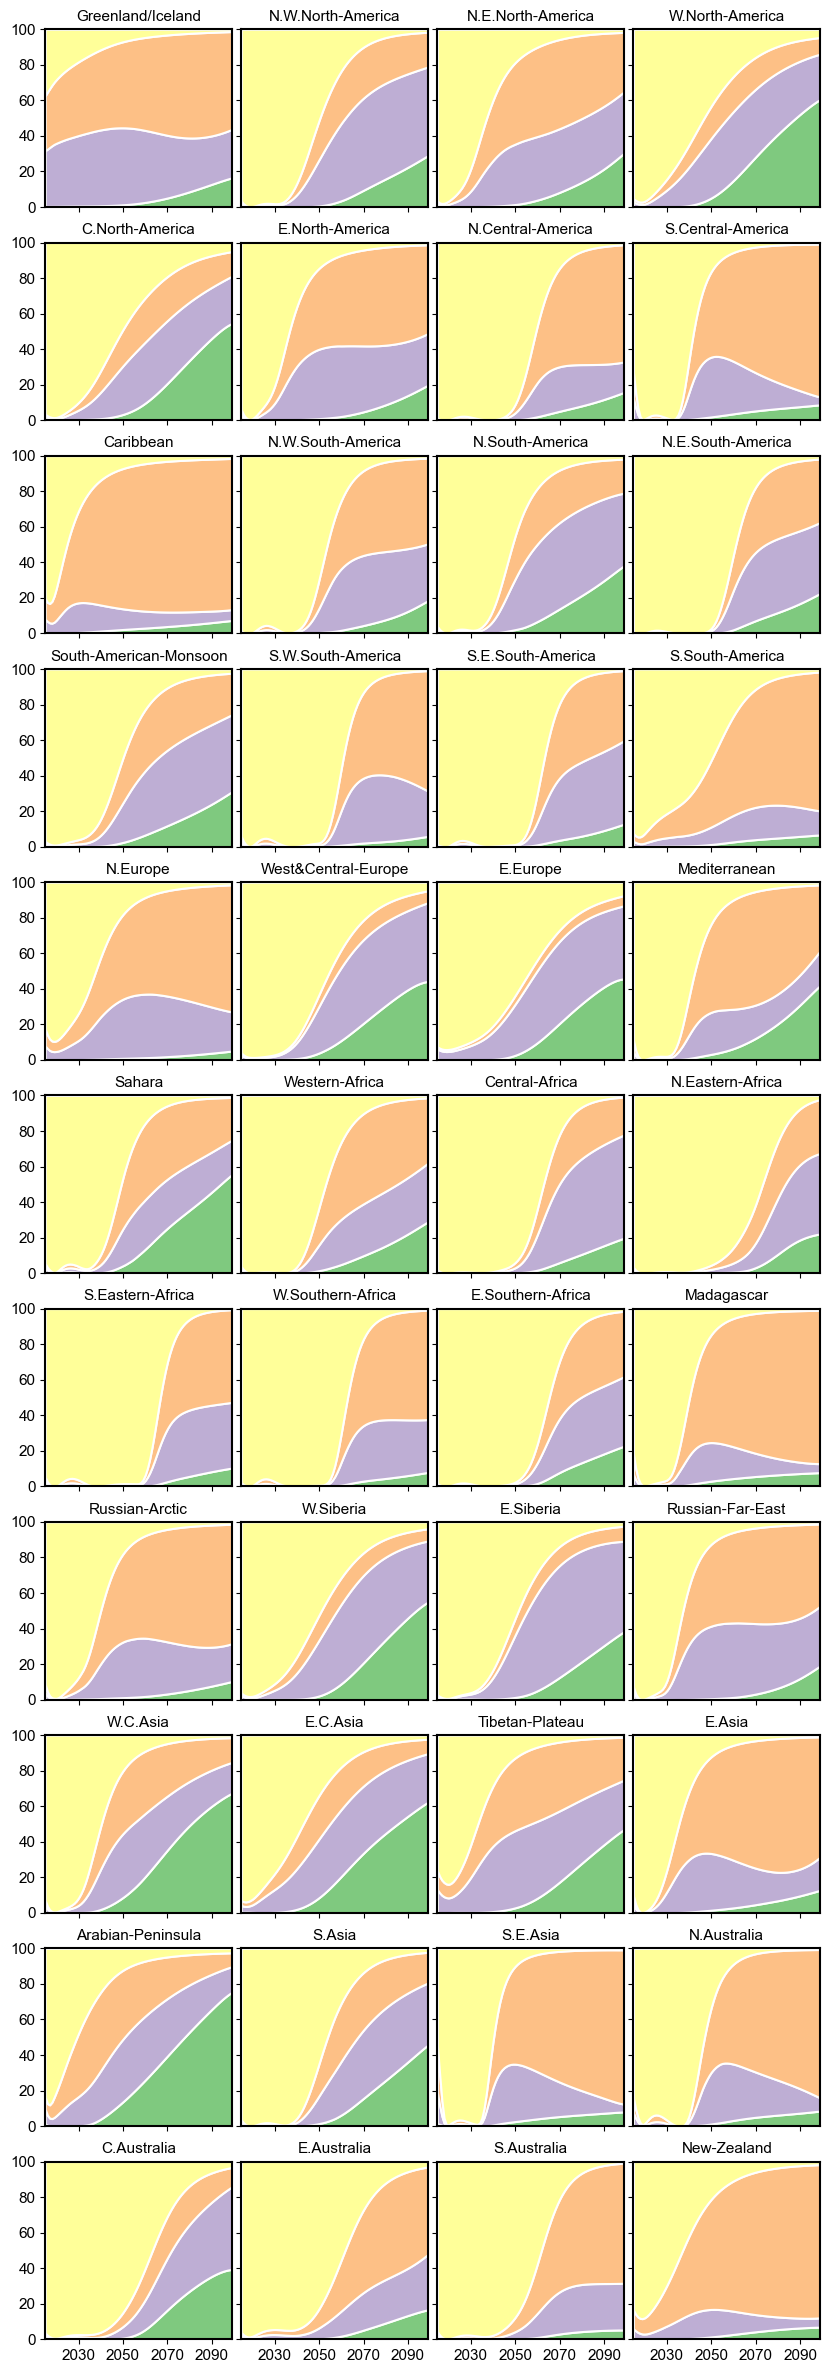

In [41]:
fig, axs = plt.subplots(11, 4, figsize=(10,30), gridspec_kw={'wspace':0.05}, sharex=True, sharey=True)
axs = axs.flatten()

deg = 4

for i, region in enumerate(regionmask.defined_regions.ar6.land.abbrevs[:-2]):
    plot_uc_timeseries_region('hot_spatial', 'tasmax', 'tasmax_q99gmfd_count',
                          region, deg, 'hs09', regionmask.defined_regions.ar6.land.names[i], '', '', False, axs[i])
    
plt.show()

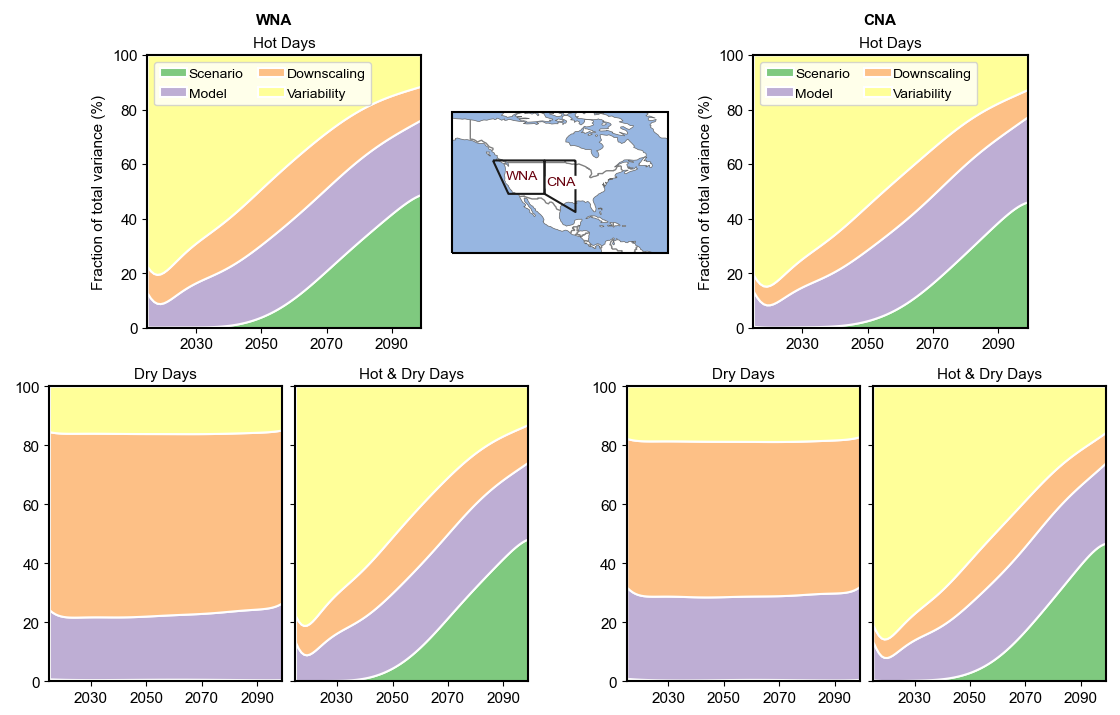

In [125]:
#################
#################
# Figure 4

plt.rcParams['font.size'] = 11
deg = 4

region_left = 'WNA'
region_right = 'CNA'

#################
#################
fig = plt.figure(figsize=(11, 7), constrained_layout=True)
subfigs = fig.subfigures(2, 1)

################
# Top row
################
top_row = subfigs[0].subfigures(1, 5, width_ratios=[0.5,3,2,3,0.5], wspace=0.1)

# Left region
ax = top_row[1].subplots(1,1)
top_row[1].suptitle(region_left, fontweight='bold', fontsize=11, x=0.55)
plot_uc_timeseries('hot', 'tasmax_q99gmfd_count',
                   region_left, deg, 'hs09', 'Hot Days', 'Fraction of total variance (%)', '', True, ax)

# Map
ax_map = top_row[2].subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()))
plot_ar6_regions([region_left, region_right], ax_map)

# Right region
ax = top_row[3].subplots(1,1)
top_row[3].suptitle(region_right, fontweight='bold', fontsize=11, x=0.55)
plot_uc_timeseries('hot', 'tasmax_q99gmfd_count',
                   region_right, deg, 'hs09', 'Hot Days', 'Fraction of total variance (%)', '', True, ax)

###############
# Bottom row
###############
axs = subfigs[1].subplots(1, 5, width_ratios=[5,5,1,5,5])

axs[2].set_axis_off()

# Left region
plot_uc_timeseries('dry', 'count_lt_1',
                   region_left, deg, 'hs09', 'Dry Days', '', '', False, axs[0])
plot_uc_timeseries('hotdry', 'hotdry_q99gmfd_count',
                   region_left, deg, 'hs09', 'Hot & Dry Days', '', '', False, axs[1])
axs[1].yaxis.set_ticklabels([])

# Right region
plot_uc_timeseries('dry', 'count_lt_1',
                   region_right, deg, 'hs09', 'Dry Days', '', '', False, axs[3])
plot_uc_timeseries('hotdry', 'hotdry_q99gmfd_count',
                   region_right, deg, 'hs09', 'Hot & Dry Days', '', '', False, axs[4])
axs[4].yaxis.set_ticklabels([])

plt.show()

In [103]:
files = !ls /gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/forced_response/hot_spatial/*_deg4.csv

In [100]:
color_dict = {'NEX': '#1b9e77', 'CIL':'#d95f02', 'ISIMIP':'#7570b3', 'GARD-SV':'#e7298a', 'DeepSD-BC':'#66a61e'}
line_dict = {'ssp585':(5, (10, 3)), 'ssp370':'dotted', 'ssp245':'dashed', 'ssp126':'dashdot'}

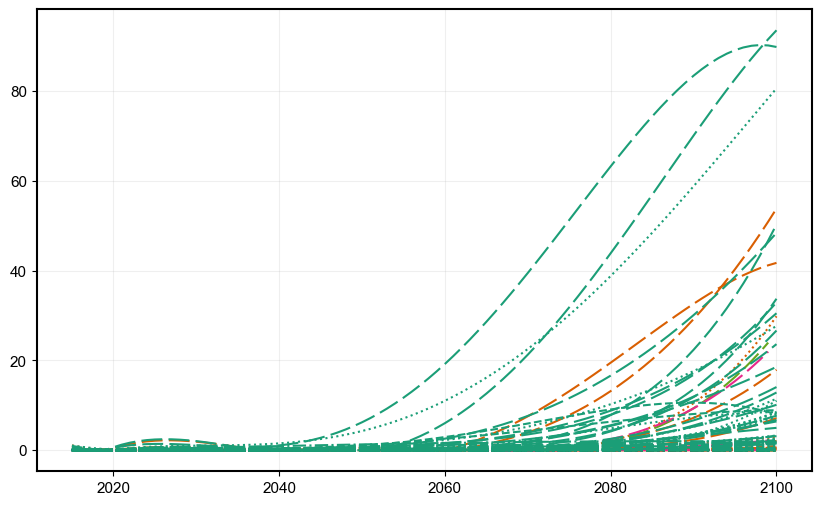

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
for file in files:
    df = pd.read_csv(file)
    for ssp in df['ssp'].unique():
        ens = file[94:-16].split('_')[0]
        if ens in ['ISIMIP']:
            continue
        df_tmp = df[(df.region == 'ENA') & (df.ssp == ssp)]
        ax.plot(df_tmp['year'], df_tmp['tasmax_q99gmfd_count'], color=color_dict[ens], ls=line_dict[ssp])
        
ax.grid(alpha=0.2)
plt.show()